# clusterizacion

Primero se procede a la carga de datos. La carga consiste en leer los comentarios de cada uno de los procesos y concatenar los que pertenecen a los comentarios de interes que se quieren guardar. Existe un comentario final que establece donde termina la secuencia de interes.

In [2]:
import sys
sys.path.append("../scripts/")
from funciones_paralectura import carga_de_datos
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

np.random.seed(15)

D = np.random.randint(1000, size=(1000, 6))
c = np.array(D[50,:])[np.newaxis]


scaler = MinMaxScaler()
scaler.fit(D)

D = scaler.transform(D)
c = scaler.transform(c)




wn = np.matmul(np.linalg.inv(np.dot(D,D.T)),np.dot(D,np.transpose(c)))

x_hat = np.matmul(D.T,(wn/np.linalg.norm(wn,ord=1)))



# x_hat = np.matmul(np.matmul(np.matmul(D.T,(np.linalg.inv(np.matmul(D,D.T)))),D),c.T)


dif = (D-x_hat.T)

# print("D: ", D[0,:])
# print("x_hat: ", x_hat.T[0])
# print("dif: ", dif[0])

# norm = np.power(np.linalg.norm(dif,axis=1),2)
norm = np.linalg.norm(dif,axis=1)

# print(norm[0])
# print(np.min(norm))

#s = 1/(1+norm)

ind = np.argmin(norm)

# print(D)
# print(c)
#print(s)
# print((D-x_hat.T))
#print(ind)
print(ind)



802


In [4]:
S = [[5,1,1,1],[1,5,4,2],[1,4,5,2],[1,2,2,5]]
s = np.array([3,3,3,3])[np.newaxis].T
lam = [1,1,1,1]
# scaler = MinMaxScaler()
# scaler.fit(S)

# S = scaler.transform(S)
# s = scaler.transform(s)
# s = s.T


# w = np.matmul((S-lam*scaler.transform(np.identity(4))),s)


w = np.matmul(np.linalg.inv((S+lam*np.identity(4))),s)

w = w/w.sum()

w

# SS = 0.5*w.T*S*w-s.T*w+0.5*w.T 


# M = np.linalg.norm(SS,axis=1)
# suma = M.sum()
# MM = M/suma
# print(w)

array([[0.35185185],
       [0.18518519],
       [0.18518519],
       [0.27777778]])

In [5]:
# carga de caminata aleatoria
documento = '../../Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post/data/Matlab/RW5.mat'
documento_2 = '../../Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post/data/Matlab/RW4.mat'
comentarios = ['discharge (random walk)',
               'rest (random walk)',
               'rest post random walk discharge']
for s in comentarios: print(s)
comentario_final = ['charge (after random walk discharge)']
for s in comentario_final: print(s)
t, v, c, temp, T = carga_de_datos(documento, comentarios, comentario_final, nofinal=False)
t_2, v_2, c_2, temp_2, T_2 = carga_de_datos(documento_2, comentarios, comentario_final, nofinal=False)

discharge (random walk)
rest (random walk)
rest post random walk discharge
charge (after random walk discharge)
carga de datos de bateria RW5.mat
tiempo len: 743
voltage len: 743
current len: 743
temperatura len: 743
Tiempo absoluto len: 743
carga de datos de bateria RW4.mat
tiempo len: 728
voltage len: 728
current len: 728
temperatura len: 728
Tiempo absoluto len: 728


## Preparacion de datos para data frame
A continuación se preparan los datos encontrando los saltos. Se recorren los arreglos de corriente, voltaje, etc, para encontrar los saltos. Correspondiente a los saltos se guardan distintas etiquetas y series de tiempo por salto.

Para cargar los datos en el data frame, se deben preparar las series de tiempo. Se toma la serie de tiempo correspondiente a la corriente como referencia. Se tomará como inicio el instante anterior al cambio de corriente, justo antes de pasar a 0 de la corriente anterior, es decir, si se estaba en 2 A, se descansa (se pasa a 0 A), y luego se pasa a 3.5 A, entonces se guardará 2.0 , 0.0, 0.0, 0.0, 3.5, 3.5, ... . El fin de la serie se toma como justo el instante antes de pasar a 0 A, siguiendo con el ejemplo anterior, la serie termina en ... , 3.5, 3.5, 0.0

In [6]:
# def guardar_serie_entre(serie, ti, deltaT, tamanno=0):
#     """
#     Funcion para guardar generar las series de tiempo a guardar en el dataframe
#     En especifico: si no se da un tamanno, se asume que es una curva de voltaje y se guarda hasta
#     el punto de mayor voltaje anterior
    
#     Input:
#         serie: serie de tiempo (arreglo de numpy)
#         ti: indice inicial de referencia para guardar los datos
#         deltaT: cantidad de puntos para guardar mas alla de ti
#         tamanno: (opcional) si no se entrega, se asume que es voltaje
#             si se entrega, se asume que se debe guardar desde ti + deltaT, la
#             cantidad de datos dada por tamanno, hacia atras.
    
#     Return:
#         entrega un arreglo de numpy con los datos pedidos
#     """
#     arr = []
        
    
#     fin = ti + deltaT
#     if fin > len(serie): fin = len(serie) - 1
#     ej = serie[ti]
#     i = 0
#     epsilon = 0.1

    
#     if tamanno != 0: i = fin - tamanno
#     else:
#         for idx in range(40):
#             if serie[ti - idx] > ej:
#                 ej = serie[ti - idx]
#                 i = idx
#             elif serie[ti - idx] < ej - epsilon: break
#         i = ti - i
    
#     if i < 0: return np.array(serie[:fin])
    
#     return np.array(serie[i : fin])

def guardar_serie_entre2(serie, ti, corriente=False, inicio=0, fin=0):
    """
    Primero entregar la corriente en el instante ti, para encontrar el inicio y el fin. El inicio de la serie
    sera el final del salto anterior, justo antes de cambiar a 0 A. Termina la serie justo en el instante anterior
    al cambiar a 0 A. Setear corriente en True
    
    Luego, pasar el inicio entregado anteriormente y el fin a las nuevas cargas de datos. Setear corriente en False
    
    """
    if corriente:
        consulta = False
        inicio = ti
        fin = ti + 2
        for i in range(10):
            if ti - i == 0:
                inicio = 0
                break
            elif serie[ti - i] == 0:
                consulta = True
            elif consulta and serie[ti - i] > 0:
                inicio = ti - i
                break
        i = 0
        while serie[ti + i] != 0:
            if ti + i == len(serie) - 1: break
            i += 1
        fin = ti + i
        return [inicio, fin, np.array(serie[inicio:fin])]
    else:
        return [inicio, fin, np.array(serie[inicio:fin])]

A continuación se sigue con la preparación. Guardando las siguientes etiquetas y datos:
- ciclo en que ocurre el salto
- energía entregada antes del momento del salto
    - para esta se intera el producto entre el voltaje y la corriente en el tiempo
- la magnitud del salto
- la media del salto
    - esto conviene cuando ocurren saltos negativos
- serie de tiempo correspondiente a voltaje, como arreglo numpy
- serie de tiempo correspondiente a corriente, como arreglo numpy
- serie de tiempo correspondiente a temperatura, como arreglo numpy
- serie de tiempo correspondiente a tiempo, como arreglo numpy

El objetivo del proceso anterior, es poder tomar cada uno de los saltos, y sacar features iterando sobre ellos.

_PD: hay muchos arreglos que solo se utilizan para graficar_

In [7]:
# creacion de vectores de diferencia de consumo de corriente

# creacion de diccionarios para guardar datos
centro_c = {}
t_salto = {}
pot = {}
pot_salto = {}
dif_salto_c = {}
centro_salto_c = {}
tiempo = {}
ciclo_salto = {}

# saltos = {}
# j = 0

arr_dif_salto_c = []
arr_pot_salto  = []
arr_centro_salto_c  = []
arr_ciclo_salto = []

arr_voltaje_salto = []
arr_corriente_salto = []
arr_tiempo_salto = []
arr_temperatura_salto = []

dx = 90

for i in c.keys():
#     if i == 0: continue
    if i == len(c.keys()) - 1: break
#     print(i)
    # creacion de vectores para guardar datos
    dif_salto_c[i] = []
    centro_c[i] = []
    centro_salto_c[i] = []
    t_salto[i] = []
    pot[i] = []
    pot_salto[i] = []
    tiempo[i] = []
    ciclo_salto[i] = []
    
    # condiciones iniciales
    anterior = 0
    POT = 0
    t_anterior = t[i][0]
    aux_t = 0
    ti = 0
    
    for idx, elem in enumerate(c[i]):
        # lectura de serie de tiempo
        
        dt = t[i][idx] - t_anterior # dt como variable auxiliar
        t_anterior = t[i][idx]
        POT += c[i][idx] * v[i][idx] * dt # se calcula la potencia integrando en el tiempo
        aux_t += dt # su acumulacion de tiempo
        
        centro_c[i].append((elem + anterior) / 2) # centro del salto
        pot[i].append(POT)
        tiempo[i].append(aux_t)
        
        if (elem - anterior >= 0.1):# or (elem - anterior <= -0.1):
            
            # solo entra si ocurre un salto
            
            dif_salto_c[i].append(elem - anterior) # magnitud del salto
            pot_salto[i].append(POT) # energia entregada al momento del salto
            centro_salto_c[i].append((elem + anterior) / 2) # media del salto
            t_salto[i].append(aux_t) # tiempo en que ocurre el salto
            ciclo_salto[i].append(i)
            
#             saltos[j] = {'ciclo': i,
#                         'energia': POT,
#                         'media': (elem + anterior) / 2,
#                         'magnitud': elem - anterior}
            
            arr_dif_salto_c.append(elem - anterior)
            arr_pot_salto.append(POT)
            arr_centro_salto_c.append((elem + anterior) / 2)
            arr_ciclo_salto.append(i)
            
            # como guardar la serie de tiempo de voltaje, corriente y temperatura 
            # del salto en un intervalo de tiempo
            dx = 90
            di = 10
            
#             aux = guardar_serie_entre(v[i], idx, 2*dx)
#             arr_voltaje_salto.append(aux)
#             arr_corriente_salto.append(guardar_serie_entre(c[i], idx, 2*dx, tamanno=len(aux)))
#             arr_tiempo_salto.append(guardar_serie_entre(t[i], idx, 2*dx, tamanno=len(aux)))
#             arr_temperatura_salto.append(guardar_serie_entre(temp[i], idx, 2*dx, tamanno=len(aux)))
            
            inicio, fin, aux = guardar_serie_entre2(c[i], idx, corriente=True)
            arr_corriente_salto.append(aux)
            _, _, aux = guardar_serie_entre2(v[i], idx, inicio=inicio, fin=fin)
            arr_voltaje_salto.append(aux)
            _, _, aux = guardar_serie_entre2(t[i], idx, inicio=inicio, fin=fin)
            arr_tiempo_salto.append(aux)
            _, _, aux = guardar_serie_entre2(temp[i], idx, inicio=inicio, fin=fin)
            arr_temperatura_salto.append(aux)
            
            ti = idx

        anterior = elem
        
        

# creacion de vectores de diferencia de consumo de corriente

# creacion de diccionarios para guardar datos
centro_c_2 = {}
t_salto_2 = {}
pot_2 = {}
pot_salto_2 = {}
dif_salto_c_2 = {}
centro_salto_c_2 = {}
tiempo_2 = {}
ciclo_salto_2 = {}

arr_dif_salto_c_2 = []
arr_pot_salto_2  = []
arr_centro_salto_c_2  = []
arr_ciclo_salto_2 = []

arr_voltaje_salto_2 = []
arr_corriente_salto_2 = []
arr_tiempo_salto_2 = []
arr_temperatura_salto_2 = []

dx_2 = 90

for i in c_2.keys():
#     if i == 0: continue
    if i == len(c_2.keys()) - 1: break
#     print(i)
    # creacion de vectores para guardar datos
    dif_salto_c_2[i] = []
    centro_c_2[i] = []
    centro_salto_c_2[i] = []
    t_salto_2[i] = []
    pot_2[i] = []
    pot_salto_2[i] = []
    tiempo_2[i] = []
    ciclo_salto_2[i] = []
    
    # condiciones iniciales
    anterior_2 = 0
    POT_2 = 0
    t_anterior_2 = t_2[i][0]
    aux_t_2 = 0
    ti_2 = 0
    
    for idx, elem in enumerate(c_2[i]):
        # lectura de serie de tiempo
        
        dt_2 = t_2[i][idx] - t_anterior_2 # dt como variable auxiliar
        t_anterior_2 = t_2[i][idx]
        POT_2 += c_2[i][idx] * v_2[i][idx] * dt_2 # se calcula la potencia integrando en el tiempo
        aux_t_2 += dt_2 # su acumulacion de tiempo
        
        centro_c_2[i].append((elem + anterior_2) / 2) # centro del salto
        pot_2[i].append(POT_2)
        tiempo_2[i].append(aux_t_2)
        
        if (elem - anterior_2 >= 0.1):# or (elem - anterior <= -0.1):
            
            # solo entra si ocurre un salto
            
            dif_salto_c_2[i].append(elem - anterior_2) # magnitud del salto
            pot_salto_2[i].append(POT_2) # energia entregada al momento del salto
            centro_salto_c_2[i].append((elem + anterior_2) / 2) # media del salto
            t_salto_2[i].append(aux_t_2) # tiempo en que ocurre el salto
            ciclo_salto_2[i].append(i)
            
#             saltos[j] = {'ciclo': i,
#                         'energia': POT,
#                         'media': (elem + anterior) / 2,
#                         'magnitud': elem - anterior}
            
            arr_dif_salto_c_2.append(elem - anterior_2)
            arr_pot_salto_2.append(POT_2)
            arr_centro_salto_c_2.append((elem + anterior_2) / 2)
            arr_ciclo_salto_2.append(i)
            
            # como guardar la serie de tiempo de voltaje, corriente y temperatura 
            # del salto en un intervalo de tiempo
            dx_2 = 90
            di_2 = 10
            
#             aux = guardar_serie_entre(v[i], idx, 2*dx)
#             arr_voltaje_salto.append(aux)
#             arr_corriente_salto.append(guardar_serie_entre(c[i], idx, 2*dx, tamanno=len(aux)))
#             arr_tiempo_salto.append(guardar_serie_entre(t[i], idx, 2*dx, tamanno=len(aux)))
#             arr_temperatura_salto.append(guardar_serie_entre(temp[i], idx, 2*dx, tamanno=len(aux)))
            
            inicio_2, fin_2, aux_2 = guardar_serie_entre2(c_2[i], idx, corriente=True)
            arr_corriente_salto_2.append(aux_2)
            _, _, aux_2 = guardar_serie_entre2(v_2[i], idx, inicio=inicio_2, fin=fin_2)
            arr_voltaje_salto_2.append(aux_2)
            _, _, aux_2 = guardar_serie_entre2(t_2[i], idx, inicio=inicio_2, fin=fin_2)
            arr_tiempo_salto_2.append(aux_2)
            _, _, aux_2 = guardar_serie_entre2(temp_2[i], idx, inicio=inicio_2, fin=fin_2)
            arr_temperatura_salto_2.append(aux_2)
            
            ti_2 = idx

        anterior_2 = elem



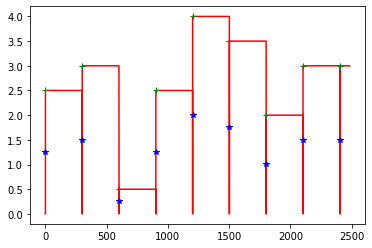

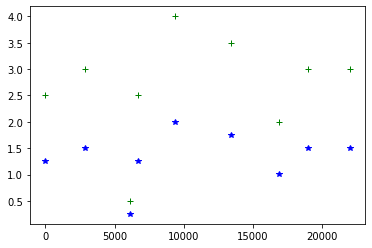

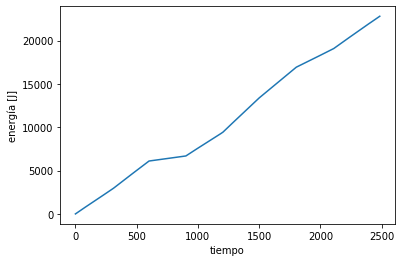

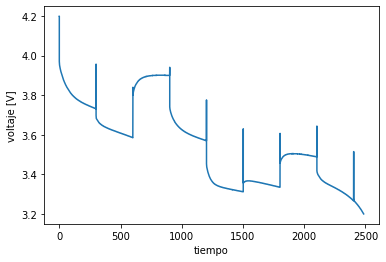

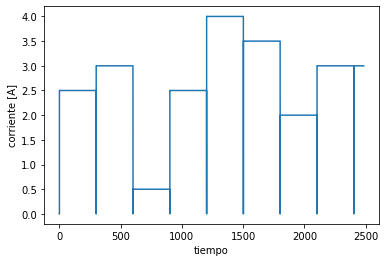

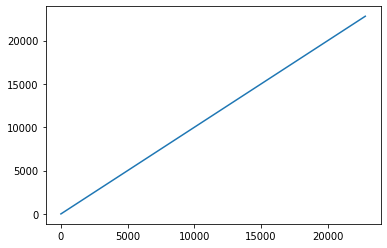

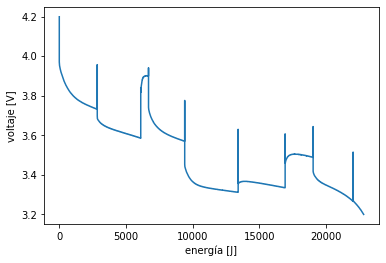

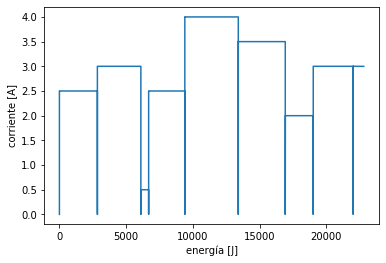

([<matplotlib.lines.Line2D at 0x23716510208>],
 Text(17.200000000000003, 0.5, 'corriente [A]'),
 Text(0.5, 17.700000000000003, 'energía [J]'),
 None)

In [8]:
# graficos
plt.plot(tiempo[2], c[2], color='r')
plt.plot(t_salto[2], dif_salto_c[2], '+g')
plt.plot(t_salto[2], centro_salto_c[2], '*b'), plt.show()

plt.plot(pot_salto[2], dif_salto_c[2], '+g')
plt.plot(pot_salto[2], centro_salto_c[2], '*b'), plt.show()

plt.plot(tiempo[2], pot[2]), plt.ylabel('energía [J]'), plt.xlabel('tiempo'), plt.show()
plt.plot(tiempo[2], v[2]), plt.ylabel('voltaje [V]'), plt.xlabel('tiempo'), plt.show()
plt.plot(tiempo[2], c[2]), plt.ylabel('corriente [A]'), plt.xlabel('tiempo'), plt.show()

plt.plot(pot[2], pot[2]), plt.show()
plt.plot(pot[2], v[2]), plt.ylabel('voltaje [V]'), plt.xlabel('energía [J]'), plt.show()
plt.plot(pot[2], c[2]), plt.ylabel('corriente [A]'), plt.xlabel('energía [J]'), plt.show()


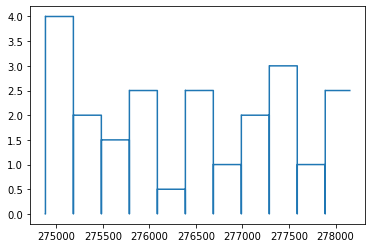

V:  4.199 3.512
C:  0.0 4.0
V:  3.512 3.72
C:  4.0 2.0
V:  3.72 3.733
C:  2.0 1.5
V:  3.733 3.543
C:  1.5 2.5
V:  3.543 3.787
C:  2.5 0.5
V:  3.787 3.474
C:  0.5 2.501
V:  3.474 3.654
C:  2.501 1.0
V:  3.654 3.489
C:  1.0 2.0
V:  3.489 3.305
C:  2.0 3.0


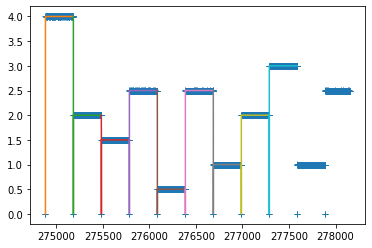

289667.11 289967.97000000003
289967.97000000003 290268.56
3.0 0.5
0.5 2.5
289066.76999999996 291552.0
0 2.999


In [9]:
# mas graficos
plt.plot(t[1], c[1]), plt.show()
plt.plot(t[1], c[1], '+')#, plt.show()
# plt.plot(t[2], c[2], '-r')
# plt.plot(t[1], v[1]), plt.show()
# plt.plot(t[2], c[2]), plt.show()
# plt.plot(t[2], v[2]), plt.show()
for i in range(9):
#     print(len(arr_voltaje_salto[i]))
    print('V: ', arr_voltaje_salto[i][0], arr_voltaje_salto[i][-1])
    print('C: ', arr_corriente_salto[i][0], arr_corriente_salto[i][-1])
#     plt.plot(arr_tiempo_salto[i], arr_voltaje_salto[i]), plt.show()
    plt.plot(arr_tiempo_salto[i], arr_corriente_salto[i])#, plt.show()
plt.show()

print(arr_tiempo_salto[13][0], arr_tiempo_salto[13][-1])
print(arr_tiempo_salto[14][0], arr_tiempo_salto[14][-1])

print(arr_corriente_salto[13][0], arr_corriente_salto[13][-1])
print(arr_corriente_salto[14][0], arr_corriente_salto[14][-1])

print(t[2][0], t[2][-1])
print(c[2][0], c[2][-1])

## Creación de dataframe
Para poder manejar de mejor manera los saltos, se agrupan en un dataframe de pandas. De esta forma, se pueden filtrar y graficar más facilmente. Además de crear nuevas columnas de manera mucho más fácil, y muchas otras facultades sobre los datos

In [10]:
import pandas as pd
saltos = {'ciclo': arr_ciclo_salto,
          'energia': arr_pot_salto,
          'magnitud': arr_dif_salto_c,
          'media': arr_centro_salto_c}
df = pd.DataFrame(saltos, columns=['ciclo', 'energia', 'magnitud', 'media'])
df['voltaje'] = [x for x in arr_voltaje_salto]
df['corriente'] = [x for x in arr_corriente_salto]
df['temperatura'] = [x for x in arr_temperatura_salto]
df['tiempo'] = [x for x in arr_tiempo_salto]


saltos_2 = {'ciclo': arr_ciclo_salto_2,
          'energia': arr_pot_salto_2,
          'magnitud': arr_dif_salto_c_2,
          'media': arr_centro_salto_c_2}
df_2 = pd.DataFrame(saltos_2, columns=['ciclo', 'energia', 'magnitud', 'media'])
df_2['voltaje'] = [x for x in arr_voltaje_salto_2]
df_2['corriente'] = [x for x in arr_corriente_salto_2]
df_2['temperatura'] = [x for x in arr_temperatura_salto_2]
df_2['tiempo'] = [x for x in arr_tiempo_salto_2]


Se agrega una etiqueta correspondiente a la temperatura inicial del momento del salto. Esto es para analizar una componente de estado de salud donde la temperatura almacena la información de la energía disipada por la transformación de energía.

Sin embargo, esta etiqueta no funciona muy bien con algún set de datos, en específico en la batería 3, donde (al parecer) se estropea el sensor de temperatura.

In [11]:
df['temp_ini'] = [x[0] for x in df['temperatura']]
df.head()
df_2['temp_ini'] = [x[0] for x in df_2['temperatura']]
df_2.head()


,ciclo,energia,magnitud,media,voltaje,corriente,temperatura,tiempo,temp_ini
0,1,0.614707,4.002,2.0010,"[4.199, 4.199, 3.84, 3.814, 3.807, 3.8, 3.795,...","[0.0, 0.0, 4.002, 4.0, 4.0, 4.0, 4.001, 4.001,...","[21.64345, 21.64345, 21.64345, 21.64345, 21.64...","[281556.4, 281556.56000000006, 281556.6, 28155...",21.64345
1,1,4268.008336,0.505,0.2525,"[3.514, 3.809, 3.836, 3.799, 3.81, 3.819, 3.82...","[4.0, 0.0, 0.0, 0.505, 0.5, 0.5, 0.5, 0.5, 0.5...","[28.38382, 28.38382, 28.38382, 28.38382, 28.38...","[281856.56000000006, 281856.56999999995, 28185...",28.38382
2,1,4858.765507,3.001,1.5005,"[3.953, 3.989, 3.991, 3.762, 3.752, 3.747, 3.7...","[0.501, 0.0, 0.0, 3.001, 3.0, 3.001, 3.0, 3.0,...","[27.29416, 27.29416, 27.29416, 27.29416, 27.29...","[282156.74, 282156.75, 282156.93, 282156.97, 2...",27.29416
3,1,8106.905952,2.007,1.0035,"[3.551, 3.769, 3.785, 3.633, 3.633, 3.635, 3.6...","[3.0, 0.0, 0.0, 2.007, 2.001, 2.001, 2.0, 2.0,...","[29.19329, 29.19329, 29.19329, 29.19329, 29.19...","[282456.93, 282456.94, 282457.11, 282457.14999...",29.19329
4,1,10293.294611,2.007,1.0035,"[3.623, 3.767, 3.776, 3.625, 3.624, 3.624, 3.6...","[2.0, 0.0, 0.0, 2.007, 2.0, 2.0, 2.0, 2.0, 2.0...","[29.16216, 29.16216, 29.16216, 29.16216, 29.16...","[282757.11, 282757.12, 282757.29000000004, 282...",29.16216


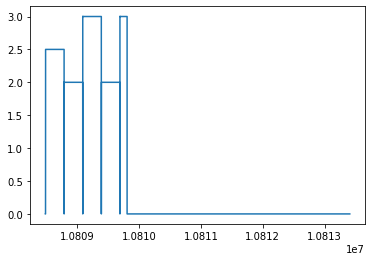

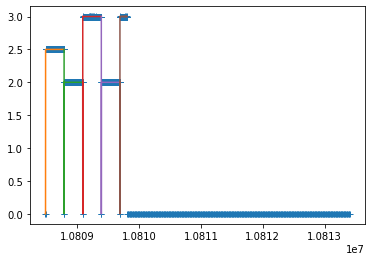

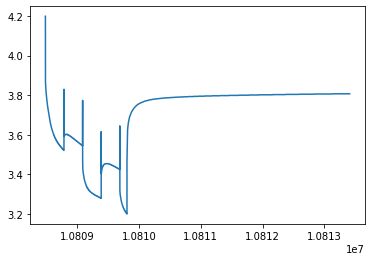

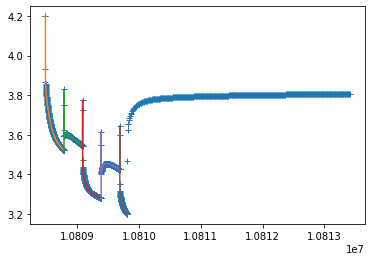

In [12]:
# mas graficos
idx = 600
plt.plot(t[idx], c[idx]), plt.show()
plt.plot(t[idx], c[idx], '+')

tiemposs = df.loc[(df['ciclo'] == idx), 'tiempo'].values
corrientos = df.loc[(df['ciclo'] == idx), 'corriente'].values

for i, tempp in enumerate(tiemposs):
    plt.plot(tempp, corrientos[i])#, plt.show()#, plt.show()
plt.show()

plt.plot(t[idx], v[idx]), plt.show()
plt.plot(t[idx], v[idx], '+')

tiemposs = df.loc[(df['ciclo'] == idx), 'tiempo'].values
voltajos = df.loc[(df['ciclo'] == idx), 'voltaje'].values

for i, tempp in enumerate(tiemposs):
    plt.plot(tempp, voltajos[i])#, plt.show()#, plt.show()
plt.show()


Análisis de histogramas, donde se pueden apreciar problemas con los datos. Pero son más gráficos solamente

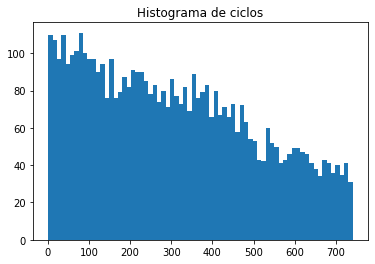

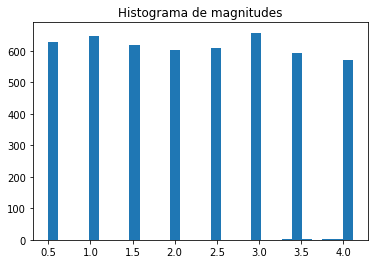

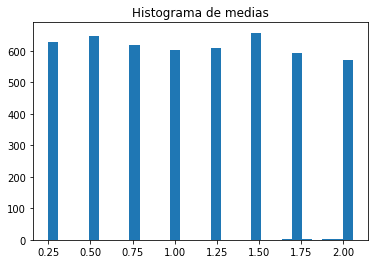

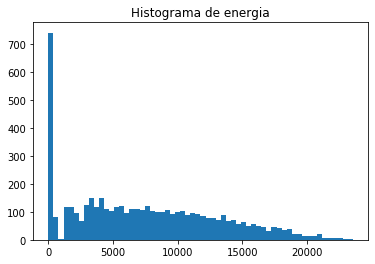

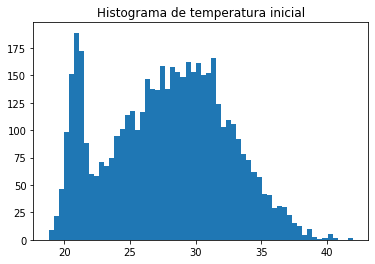

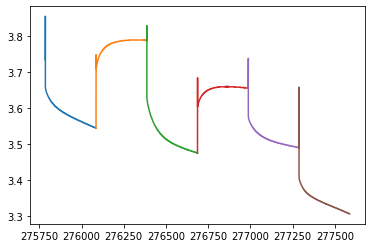

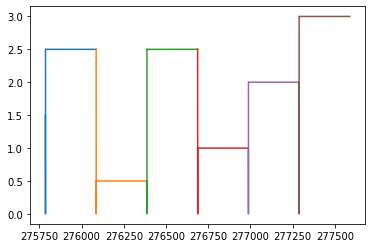

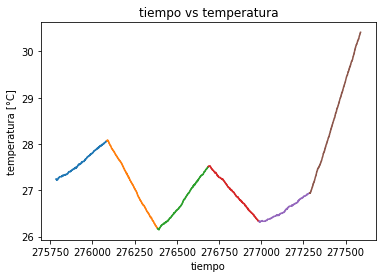

In [13]:
# analisis estadistico de los ciclos: ploteo de histogramas
plt.hist(df['ciclo'], bins=70), plt.title('Histograma de ciclos'), plt.show()
plt.hist(df['magnitud'], bins=30), plt.title('Histograma de magnitudes'), plt.show()
plt.hist(df['media'], bins=30), plt.title('Histograma de medias'), plt.show()
plt.hist(df['energia'], bins=60), plt.title('Histograma de energia'), plt.show()
# print(len(df))
# df_2['temp_ini'] = df['temp_ini'].drop(index=[df['temp_ini'] <= 0][0] * np.arange(0, len(df)))
# print(len(df_2))
plt.hist(df['temp_ini'], bins=60), plt.title('Histograma de temperatura inicial'), plt.show()

for i in range(3,9):
    plt.plot(df['tiempo'][i], df['voltaje'][i])
plt.show()

for i in range(3,9):
    plt.plot(df['tiempo'][i], df['corriente'][i])
plt.show()

for i in range(3,9):
    plt.plot(df['tiempo'][i], df['temperatura'][i])
    plt.title('tiempo vs temperatura')
    plt.xlabel('tiempo')
    plt.ylabel('temperatura [°C]')
plt.show()


## Features
A continuación, se definen los features a utilizar para encontrar tendencias entre los datos.

Primero, se quiere encontrar alguna relación con la componente resistiva de la respuesta dinámica, para ello se analiza la diferencia de voltaje entre los primeros instantes de tiempo. Hay que mejorar esto, ya que está medio hardcodeado, se debe analiza cuando la corriente no es nula

In [14]:
# definiendo features
# def primera_derivada(arr_serie):
#     aux = []
#     for serie in arr_serie:
#         serie = serie[2:]
#         #aux2 = list(serie[:-1] - serie[1:])
#         aux2 = list(np.diff(serie))
#         if len(aux2) == 0: aux2 = [0]
#         aux.append(aux2)
#     return aux



def primera_derivada(data_1,data_2):
    aux = []
    for i in range(len(data_1)):
        der_mean = np.mean(np.diff(data_1[i][2:])/10)
        aux.append(der_mean)
    return aux    

# segunda derivada
# def segunda_derivada(data):
#     aux = []
#     for i in data:
#         der_mean = np.mean(np.diff(np.diff(i)))
#         aux.append(der_mean)
#     return aux

def segunda_derivada(data_1,data_2):
    aux = []
    for i in range(len(data_1)):
        der_mean = np.mean(np.diff(np.diff(data_1[i][2:]))/100)
        aux.append(der_mean)
    return aux

#Delta temperatura
def deltaT(arr_serie, magnitud):
    data = arr_serie.values
    mag = magnitud.values
    aux = data[1:]-data[:-1]
    aux = np.insert(aux,0,data[0])
    aux = abs(aux/mag)
    return aux

#Efecto capacitivo

#validacion
def Valid_data(data):
    if len(data)>100:
        ini = (data[15]-data[7]) > 0 
        final = [False,0]
        aux = 0
        index = 0
        if ini == True:
            for i in range(len(data)-1):
                if (data[i+1]-data[i]) <=0 :
                    if aux == 0:
                        index = i
                    aux += 1
                    if aux == 25:
                        final = [True,index]
                        break
                else:
                    aux = 0
        if ini == True and final[0] == True:
            return [True,final[1]]
        else:
            return [False,0]
    else:
        return [False,0]

    
def primera_derivada_RC(data):
    aux = []
    for i in data:
        valid = Valid_data(i)
        if valid[0] == True:
            inf = valid[1]
            der_mean = np.mean(np.diff(i[:inf])/10)
            aux.append(der_mean)
        else:
            aux.append(0)
    return aux

def segunda_derivada_RC(data):
    aux = []
    for i in data:
        valid = Valid_data(i)
        if valid[0] == True:
            inf = valid[1]
            der_mean = np.mean(np.diff(np.diff(i[:inf]))/100)
            aux.append(der_mean)
        else:
            aux.append(0)
    return aux
    
def RC(data,time,ind):
    aux = []
    aux_2 = []
    for i in range(len(data)):
        valid = Valid_data(data[i])
        if valid[0] == True:
            inf = valid[1]
            Rc = (time[i][inf]-time[i][0])*0.632
            aux.append(Rc)
        else:
            aux.append(0)
    n = max(ind)
    k = 0
    for i in range(n-1):
        ind_aux = np.where(ind.values ==i+1)
        k += len(ind_aux[0])
        if len(ind_aux[0]) > 0:
            ini_aux = ind_aux[0][0]
            final_aux = ind_aux[0][-1]
            #print(ini_aux,final_aux)
            mean = np.mean(aux[ini_aux:final_aux])    
            kk = [mean]*len(ind_aux[0])
            aux_2 = np.append(aux_2, kk)
        else:
            aux_2 = np.append(aux_2, 0)
    return [aux,aux_2]

# comportamiento de potencia instantanea entregada
def potencia_instantanea_salto(arr_voltaje, arr_corriente, limite=10):
    aux = np.zeros(len(arr_voltaje))
    for i, serie in enumerate(arr_corriente):
        serie = serie[1:]
        contador = 0
        for j, c in enumerate(serie):
            if c != 0 and aux[i] == 0:
                aux[i] = c * arr_voltaje[i][j]
                contador = 1
            elif c != 0 and contador < limite:
                aux[i] += c * arr_voltaje[i][j]
                contador += 1
            elif contador == limite: break
            
    return aux

def ChangeLabel(Data, n):
    maxi = max(Data)
    mini = min(Data)
    size = maxi/n
    labels = [int((i-mini)/size)+1 for i in Data]
    return labels
    
# comportamiento de potencia instantanea entregada
def potencia_instantanea_salto(arr_voltaje, arr_corriente, limite=10):
    aux = np.zeros(len(arr_voltaje))
    for i, serie in enumerate(arr_corriente):
        serie = serie[1:]
        contador = 0
        for j, c in enumerate(serie):
            if c != 0 and aux[i] == 0:
                aux[i] = c * arr_voltaje[i][j]
                contador = 1
            elif c != 0 and contador < limite:
                aux[i] += c * arr_voltaje[i][j]
                contador += 1
            elif contador == limite: break
            
    return aux

#Magnitud relativa al consumo anterior
def Mg_rel (data):
    data = data.values
    aux  = data[1:]-data[:-1]
    aux = np.insert(aux,0,data[0])
    aux_2 = aux/2 
    return [aux,aux_2]

#Energia total consumida 
def energia_total(data_ene,data_ciclo):
    ene = np.zeros(len(data_ene))
    data_ene = data_ene.values
    data_ciclo = data_ciclo.values
    aux = 1
    ind_aux = 0
    for i in range(len(data_ene)):
        if data_ciclo[i] == 1:
            ene[i] = data_ene[i]
        elif data_ciclo[i] != aux:
            aux = data_ciclo[i]
            ind_aux = i-1
            ene[i] = ene[ind_aux]+data_ene[i]
        else:
             ene[i] = ene[ind_aux] + data_ene[i]    
    return ene
    

In [15]:
ene = df["corriente"][0]*df["voltaje"][0]
a = np.array([1,2,3,4])
np.power(a,2)

array([ 1,  4,  9, 16], dtype=int32)

In [16]:
# obtener features

#RW3
df["ene_total"] = energia_total(df["energia"],df["ciclo"])

mag = Mg_rel(df['magnitud'])
df["Mag_rel"] = mag[0] #magnitud relativa a la anterior
df["Mediana_rel"] = mag[1] #mediana relativa
df["Mag_rel_abs"] = np.absolute(mag[0]) #magnitud relativa a la anterior
df["Mediana_rel_abs"] = np.absolute(mag[1]) #mediana relativa

#df["F1"] = [np.mean(x[:1]) for x in primera_derivada(df["voltaje"])] #primera derivada
df["F1"] = primera_derivada(df["voltaje"],df["tiempo"])
#df["F2"] = segunda_derivada(df["voltaje"]) #segunda derivada
df["F2"] = segunda_derivada(df["voltaje"],df["tiempo"]) 
df["F3"] = deltaT(df["temp_ini"],df["magnitud"])  #Diferencia de temperatura
df["F4"] = primera_derivada_RC(df["voltaje"])  # primera derivada efecto capacitivo
df["F5"] = segunda_derivada_RC(df["voltaje"])  # segunda derivada efecto capacitivo
RC_test = RC(df["voltaje"],df["tiempo"],df["ciclo"])
df["F6"] = RC_test[0]  # circuito RC
df["F7"] = potencia_instantanea_salto(df['voltaje'], df['corriente'], limite=1) #Potencia instantanea
df["F8"] = np.round(df["F7"].values/df["Mag_rel"].values,3)
df["F9"] =  np.round(df["F7"].values/df["Mag_rel_abs"].values,3)
#RW5
df_2["ene_total"] = energia_total(df_2["energia"],df_2["ciclo"])

mag = Mg_rel(df_2['magnitud'])
df_2["Mag_rel"] = mag[0] #magnitud relativa a la anterior
df_2["Mediana_rel"] = mag[1] #mediana relativa
df_2["Mag_rel_abs"] = np.absolute(mag[0]) #magnitud relativa a la anterior
df_2["Mediana_rel_abs"] = np.absolute(mag[1]) #mediana relativa

#df_2["F1"] = [np.mean(x[:1]) for x in primera_derivada(df_2["voltaje"])]
df_2["F1"] = primera_derivada(df_2["voltaje"],df_2["tiempo"])
#df_2["F2"] = segunda_derivada(df_2["voltaje"]) #segunda derivada
df_2["F2"] = segunda_derivada(df_2["voltaje"],df_2["tiempo"]) 
df_2["F3"] = deltaT(df_2["temp_ini"],df_2["magnitud"])
df_2["F4"] = primera_derivada_RC(df_2["voltaje"])  # primera derivada efecto capacitivo
df_2["F5"] = segunda_derivada_RC(df_2["voltaje"])  # segunda derivada efecto capacitivo
RC_test = RC(df_2["voltaje"],df_2["tiempo"],df_2["ciclo"])
df_2["F6"] = RC_test[0]  # circuito RC
df_2["F7"] = potencia_instantanea_salto(df_2['voltaje'], df_2['corriente'], limite=1) #Potencia instantanea
df_2["F8"] = np.round(df_2["F7"].values/df_2["Mag_rel"].values,3)
df_2["F9"] = np.round(df_2["F7"].values/df_2["Mag_rel_abs"].values,3)
#Cambio de labels para etiquetar

sep = 8
df["clase"] = ChangeLabel(df['ciclo'],sep)
df_2["clase"] = ChangeLabel(df_2["ciclo"],sep)

#print(df["F7"].values/df["Mag_rel"].values)
#df.values[1393,:]
df

C:\Users\cbaez\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\cbaez\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


,ciclo,energia,magnitud,media,voltaje,corriente,temperatura,tiempo,temp_ini,ene_total,...,F1,F2,F3,F4,F5,F6,F7,F8,F9,clase
0,1,0.614047,4.005,2.0025,"[4.199, 4.199, 3.833, 3.809, 3.801, 3.795, 3.7...","[0.0, 0.0, 4.005, 3.999, 4.0, 3.999, 4.0, 4.0,...","[20.61039, 20.61039, 20.61039, 20.62594, 20.62...","[274884.25, 274884.5, 274884.54, 274885.540000...",20.61039,6.140466e-01,...,-0.000107,8.026756e-07,5.146165,0.000000,0.000000,0.00000,16.816995,4.199,4.199,1
1,1,4266.690109,2.007,1.0035,"[3.512, 3.817, 3.842, 3.683, 3.688, 3.693, 3.6...","[4.0, 0.0, 0.0, 2.007, 2.0, 2.0, 2.0, 2.0, 2.0...","[28.18093, 28.18093, 28.18093, 28.18093, 28.21...","[275184.5, 275184.50999999995, 275184.7, 27518...",28.18093,4.266690e+03,...,-0.000041,5.300000e-06,3.772068,0.000213,-0.000027,70.30368,7.710894,-3.859,3.859,1
2,1,6510.697143,1.503,0.7515,"[3.72, 3.868, 3.879, 3.763, 3.762, 3.763, 3.76...","[2.0, 0.0, 0.0, 1.503, 1.5, 1.5, 1.5, 1.5, 1.5...","[28.36748, 28.36748, 28.36748, 28.36748, 28.35...","[275484.7, 275484.71, 275485.35, 275485.39, 27...",28.36748,6.510697e+03,...,-0.000049,3.866667e-06,0.124118,0.000107,-0.000034,26.98008,5.830137,-11.568,11.568,1
3,1,8200.072656,2.504,1.2520,"[3.733, 3.846, 3.854, 3.657, 3.652, 3.65, 3.64...","[1.5, 0.0, 0.0, 2.504, 2.5, 2.5, 2.5, 2.499, 2...","[27.24822, 27.24822, 27.23267, 27.23267, 27.23...","[275785.35, 275785.36, 275785.81, 275785.85, 2...",27.24822,8.200073e+03,...,-0.000103,6.533333e-06,0.446989,0.000000,0.000000,0.00000,9.650416,9.641,9.641,1
4,1,10884.859898,0.504,0.2520,"[3.543, 3.731, 3.747, 3.708, 3.711, 3.715, 3.7...","[2.5, 0.0, 0.0, 0.504, 0.5, 0.5, 0.5, 0.5, 0.5...","[28.07212, 28.07212, 28.07212, 28.07212, 28.07...","[276085.81, 276085.82, 276086.28, 276086.33, 2...",28.07212,1.088486e+04,...,0.000013,1.300000e-06,1.634722,0.000145,-0.000011,105.24064,1.888488,-0.944,0.944,1
5,1,11451.628610,2.505,1.2525,"[3.787, 3.825, 3.828, 3.629, 3.623, 3.619, 3.6...","[0.5, 0.0, 0.0, 2.505, 2.499, 2.5, 2.5, 2.5, 2...","[26.17559, 26.17559, 26.17559, 26.17559, 26.16...","[276386.28, 276386.29000000004, 276386.87, 276...",26.17559,1.145163e+04,...,-0.000118,6.600000e-06,0.757098,0.000000,0.000000,0.00000,9.589140,4.792,4.792,1
6,1,14086.032912,1.005,0.5025,"[3.474, 3.663, 3.683, 3.603, 3.604, 3.607, 3.6...","[2.501, 0.0, 0.0, 1.005, 1.0, 0.999, 1.0, 0.99...","[27.51249, 27.51249, 27.51249, 27.51249, 27.51...","[276686.87, 276686.88, 276687.33, 276687.37, 2...",27.51249,1.408603e+04,...,-0.000010,2.666667e-06,1.330249,0.000140,-0.000015,81.84400,3.701415,-2.468,2.468,1
7,1,15181.589734,2.005,1.0025,"[3.654, 3.73, 3.737, 3.576, 3.571, 3.569, 3.56...","[1.0, 0.0, 0.0, 2.005, 2.0, 2.0, 2.0, 2.0, 2.0...","[26.33105, 26.33105, 26.33105, 26.33105, 26.31...","[276987.33, 276987.34, 276987.88, 276987.92000...",26.33105,1.518159e+04,...,-0.000082,5.366667e-06,0.589247,0.000000,0.000000,0.00000,7.492685,7.493,7.493,1
8,1,17288.851126,3.003,1.5015,"[3.489, 3.64, 3.657, 3.412, 3.403, 3.401, 3.39...","[2.0, 0.0, 0.0, 3.003, 3.001, 3.0, 3.0, 3.0, 3...","[26.93731, 26.93731, 26.93731, 26.93731, 26.95...","[277287.88, 277287.89, 277288.08, 277288.12, 2...",26.93731,1.728885e+04,...,-0.000117,8.166667e-06,0.201885,0.000000,0.000000,0.00000,10.981971,11.004,11.004,1
9,1,20293.072460,1.002,0.5010,"[3.305, 3.528, 3.559, 3.479, 3.484, 3.489, 3.4...","[3.0, 0.0, 0.0, 1.002, 1.001, 0.999, 1.0, 0.99...","[30.41535, 30.41535, 30.41535, 30.41535, 30.43...","[277588.08, 277588.08999999997, 277588.32, 277...",30.41535,2.029307e+04,...,0.000005,2.666667e-06,3.471098,0.000209,-0.000017,80.44096,3.566118,-1.782,1.782,1


C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using t

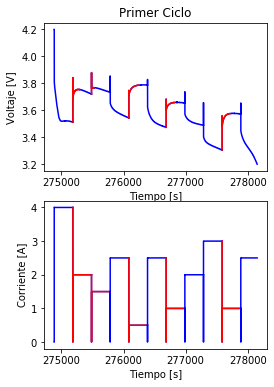

In [52]:
plt.figure(figsize=(4,6))
for i in range(11):
    plt.subplot(211)
    plt.plot(df["tiempo"][i],df["voltaje"][i],color='b')
    plt.subplot(212)
    plt.plot(df["tiempo"][i],df["corriente"][i],color='b')
    if(i == 1 or i == 2 or i == 4 or i == 6 or i == 9):
        valid = Valid_data(df["voltaje"][i])
        plt.subplot(211)
        plt.plot(df["tiempo"][i][:valid[1]],df["voltaje"][i][:valid[1]],color='r')
        plt.subplot(212)
        plt.plot(df["tiempo"][i],df["corriente"][i],color='r')
 


        
plt.subplot(211)
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Primer Ciclo")        
plt.subplot(212)
plt.xlabel("Tiempo [s]")
plt.ylabel("Corriente [A]")

plt.show()


In [18]:
def poprow(my_array,pr):
    """ row popping in numpy arrays
    Input: my_array - NumPy array, pr: row index to pop out
    Output: [new_array,popped_row] """
    i = pr
    pop = my_array[i,:]
    new_array = np.vstack((my_array[:i,:],my_array[i+1:,:]))
    return [new_array,pop]

def popcol(my_array,pc):
    """ column popping in numpy arrays
    Input: my_array: NumPy array, pc: column index to pop out
    Output: [new_array,popped_col] """
    i = pc
    pop = my_array[:,i]
    new_array = np.hstack((my_array[:,:i],my_array[:,i+1:]))
    return [new_array,pop]


def Mean_n(data, n):
    aux = np.zeros(len(data))
    rg = int(len(data)/n)
    for i in range(rg):
        aux[i*n:i*n+n] =  np.round(np.median(data[i*n:i*n+n])+0.1)
    if(i*n+n<len(data)):
        aux[i*n+n:] = np.round(np.median(data[i*n+n:])+0.1)
    return aux

def data_valid(data_x,data_y,porcentaje,n,rs=None):
    "esta funcion entrega el conjunto de validacion"
    "porcentaje = cantidad de datos minimos del conjunto total que se quieren como conjunto de validación"
    "n = numero de elementos consecutivos que se quieren tomar en el conjunto de validación"
    data_valid_x = np.empty((0,data_x.shape[1]))
    data_valid_y = []
    "Se reordenan los datos para poder trabajarlo apropiadamente"
    new_data_x = data_x
    new_data_y = np.reshape(data_y,(1,-1))
    "porcentaje de parada"
    por_stop = porcentaje/(100-porcentaje)
    por_act = 0
    l = len(new_data_x)-1
    while(por_act<por_stop):
        "Si el conjunto de validación tiene menos % de lo pedido"
        idx = np.random.randint(0,l) "Se genera un indice random"
        idx_fn = idx+n-1
        if(idx_fn<l):
            for i in range(n):
                idx_act = idx
                "Se genera el valor extraido y el conjunto sin ese valor n veces"
                pop_x = poprow(new_data_x,idx_act)
                pop_y = popcol(new_data_y,idx_act)
                "El valor popeado esta en [1] y el conjunto sin el valor en [0]"
                "Por lo que en el conjunto de validación hay que ir adjuntando"
                data_valid_x = np.append(data_valid_x,np.reshape(pop_x[1],(1,-1)),axis=0)
                data_valid_y = np.append(data_valid_y,pop_y[1])
                "Por lo que en el conjunto de entrenamiento no se necesitan adjuntar los datos"
                new_data_x = pop_x[0]
                new_data_y = pop_y[0]
        l = new_data_x.shape[0]-1
        l_valid = data_valid_x.shape[0]-1
        "se toma el pocentaje acutal para ver si se cumple la condición"
        por_act = l_valid/l
    np.random.seed(rs)
    "Se juntan los label en el conjunto de entrenamiento para luego mezclar"
    data_train = np.hstack((new_data_x,np.reshape(new_data_y,(-1,1))))
    np.random.shuffle(data_train)
    "Se obtiene los conjuntos de entrenamiento y validacion separados en x e y"
    data_train_x = data_train[:,:-1]
    data_train_y = data_train[:,-1]
    return [data_train_x,data_train_y,data_valid_x,data_valid_y]
            
    

In [19]:
import tensorflow as tf
import seaborn as sns
from math import floor, ceil
from pylab import rcParams
from time import time
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif,chi2
from sklearn import svm
from sklearn.model_selection import GridSearchCV



"Se toman los valores de ambos conjuntos y se concatenan"
data_1 = df.values
data_2 = df_2.values
data = np.vstack((data_1,data_2))
# np.random.shuffle(data)
"Se toman los nombres para luego printear"
Nombres = df.columns.values

"Se filtra segun energia y se eliminan valores problematicos como NaN o inf"
print("after filter: ", data.shape)
energi= 1500
ind = np.where((data[:,1]>1500)) 
data = np.delete(data,ind,axis=0)
print("firt filter energia >%s: " %energi , data.shape)

# ind = np.where((data[:,1]<150)) 
# data = np.delete(data,ind,axis=0)
# print("firt filter energia <150: " , data.shape)

aux = data[:,15].astype(np.float64)
ind_2 = np.argwhere(np.isnan(aux))
data = np.delete(data,ind_2,axis=0)
print("second filter F2 = Nan:" , data.shape)

aux_2 = data[:,21].astype(np.float64)
ind_3 = np.argwhere(np.isinf(aux_2))
data = np.delete(data,ind_3,axis=0)
print("second filter F8 = inf:" , data.shape)

# Data con energia total consumida

#data_x = np.hstack((data[:,3:5],data[:,9:22]))
#Data sin energia total consumida

data_temp = np.reshape(data[:,8],(-1,1))
#print(data_temp.shape)
# data_x = np.hstack((data[:,3:5],data_temp,data[:,11:22]))
data_x = np.hstack((data[:,1:4],data_temp,data[:,10:23]))
Nombres_featu = np.hstack((Nombres[1:4],Nombres[8],Nombres[10:23]))


data_y = data[:,-1]
data_y = data_y.astype(int)
#print("datax: ",data_x.shape)

"Se aplica un scaler a los datos"
scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(data_x)
# data_x = PCA(n_components=8).fit_transform(scaler_data)

"Se eligen las mejores k caracteristicas"
Sel_best = SelectKBest(mutual_info_classif, k=7)
Sel_best.fit(scaler_data, data_y)
Best_Sel = Sel_best.get_support()
Data_sel = [str(Nombres_featu[i])+":"+ str(Best_Sel[i]) for i in range(len(Best_Sel))]
print(Data_sel)

data_x = Sel_best.transform(scaler_data)
# data_aux = np.reshape(scaler_data[:,-1],(-1,1))
# data_x = np.hstack((data_x,data_aux))

#print(data_x.shape)

#Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve
from sklearn.model_selection import train_test_split


win = 12 "Tamaño de ventana de valores consecutivos"


"Se toman los datos separados y mezclados"
x_train, y_train, x_valid, y_valid = data_valid(data_x, data_y,30, win)
# y_valid = y_valid.reshape((-1,1))
# data_valid = np.hstack((x_valid,y_valid))
# data_valid = data_valid[data_valid[:,-1].argsort()]
# x_valid = data_valid[:,:-1]
# y_valid = data_valid[:,-1]

#print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)
"Se clasifican utilizando random forest"
regressor = RandomForestClassifier(n_estimators=150)
regressor.fit(x_train , y_train)

y_pred_act = regressor.predict(x_valid) "Valor por label antes de aplicar la mediana de tamaño win"

# print("Random Forest scores before fit:")
# print(accuracy_score(y_valid, y_pred_act))
# print(confusion_matrix(y_valid, y_pred_act))


y_pred = Mean_n(y_pred_act,win) "Valor por label utilizando la mediana"


# for i in range(len(y_pred)):
#     print(i,y_pred_act[i],y_pred[i],y_valid[i])


# print("Random Forest scores after fit:")
# print(accuracy_score(y_valid, y_pred))
# print(confusion_matrix(y_valid, y_pred))
# print(regressor.feature_importances_)

print("Random Forest=","W:", win,"accu_pre_fit: ",accuracy_score(y_valid, y_pred_act),"accu_post_fit: ",accuracy_score(y_valid, y_pred))
        
# from sklearn.neural_network import MLPClassifier

# clf = MLPClassifier(solver='lbfgs', alpha=10, hidden_layer_sizes=(20,20,20), random_state=1, dropout=10)

# clf.fit(x_train , y_train)

# y_pred_mlp_act = clf.predict(x_valid)

# y_pred_mlp = Mean_n(y_pred_mlp_act,win)

# print("MLP=","W:", win,"accu_pre_fit: ",accuracy_score(y_valid, y_pred_mlp_act),"accu_post_fit: ",accuracy_score(y_valid, y_pred_mlp))


after filter:  (9672, 24)
firt filter energia >1500:  (1893, 24)
second filter F2 = Nan: (1893, 24)
second filter F8 = inf: (1827, 24)
Random Forest= W: 12 accu_pre_fit:  0.7427536231884058 accu_post_fit:  0.8659420289855072


In [ ]:
## análisis de sensibilidad por ventana
win = 30
n_try = 20
accu = np.zeros((n_try,win))

for j in range(n_try):
    for i in range(win):
        x_train, y_train, x_valid, y_valid = data_valid(data_x, data_y,30,i+1,j)
        # y_valid = y_valid.reshape((-1,1))
        # data_valid = np.hstack((x_valid,y_valid))
        # data_valid = data_valid[data_valid[:,-1].argsort()]
        # x_valid = data_valid[:,:-1]
        # y_valid = data_valid[:,-1]

        #print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

        regressor = RandomForestClassifier(n_estimators=150)
        regressor.fit(x_train , y_train)
        y_pred_act = regressor.predict(x_valid)

        # print("Random Forest scores before fit:")
        # print(accuracy_score(y_valid, y_pred_act))
        # print(confusion_matrix(y_valid, y_pred_act))


        y_pred = Mean_n(y_pred_act,i+1)


        # for i in range(len(y_pred)):
        #     print(i,y_pred_act[i],y_pred[i],y_valid[i])


        # print("Random Forest scores after fit:")
        # print(accuracy_score(y_valid, y_pred))
        # print(confusion_matrix(y_valid, y_pred))
        # print(regressor.feature_importances_)
        accu[j,i] = accuracy_score(y_valid, y_pred)
        print("rs: ",j,"W:", i+1,"accu_pre_fit: ",accuracy_score(y_valid, y_pred_act),"accu_post_fit: ",accuracy_score(y_valid, y_pred))
        
accu_mean = np.mean(accu,axis=0)
accu_std = np.std(accu,axis = 0)
ran = np.arange(len(accu_mean))

plt.errorbar(ran,accu_mean,accu_std,linestyle='None',marker='^',ecolor='r',c='b')
plt.xlabel("Window")
plt.ylabel("accuracy")
plt.title("analisis de sensibilidad, %s iteraciones" %n_try)

In [ ]:
## senbilidad de acuerdo a la energia consumida
data_1 = df.values
data_2 = df_2.values
data = np.vstack((data_1,data_2))
# np.random.shuffle(data)
Nombres = df.columns.values


jump_ene = 10
n_try = 20
accu_ene = np.zeros((n_try,jump_ene))


for j in range(n_try):
    for i in range(jump_ene):
        #16 = f2 17=f3
        #print("after filter: ", data.shape)
        energi= 500+500*i
        ind = np.where((data[:,1]>energi)) 
        data_fil = np.delete(data,ind,axis=0)
        #print("firt filter energia >%s: "%energi, data_fil.shape)

        # ind = np.where((data[:,1]<150)) 
        # data = np.delete(data,ind,axis=0)
        # print("firt filter energia <150: " , data.shape)

        aux = data_fil[:,15].astype(np.float64)
        ind_2 = np.argwhere(np.isnan(aux))
        data_fil = np.delete(data_fil,ind_2,axis=0)
        #print("second filter F2 = Nan:" , data_fil.shape)

        aux_2 = data_fil[:,21].astype(np.float64)
        ind_3 = np.argwhere(np.isinf(aux_2))
        data_fil = np.delete(data_fil,ind_3,axis=0)
        #print("second filter F8 = inf:" , data.shape)

        ## Data con energia total consumida

        ##data_x = np.hstack((data[:,3:5],data[:,9:22]))
        #Data sin energia total consumida

        data_temp = np.reshape(data_fil[:,8],(-1,1))
        #print(data_temp.shape)
        # data_x = np.hstack((data[:,3:5],data_temp,data[:,11:22]))
        data_x = np.hstack((data_fil[:,1:4],data_temp,data_fil[:,10:23]))
        Nombres_featu = np.hstack((Nombres[1:4],Nombres[8],Nombres[10:23]))


        data_y = data_fil[:,-1]
        data_y = data_y.astype(int)
        #print("datax: ",data_x.shape)

        scaler = StandardScaler()
        #scaler = MinMaxScaler()
        scaler_data = scaler.fit_transform(data_x)
        # data_x = PCA(n_components=8).fit_transform(scaler_data)

        Sel_best = SelectKBest(mutual_info_classif, k=6)
        Sel_best.fit(scaler_data, data_y)
        Best_Sel = Sel_best.get_support()
        Data_sel = [str(Nombres_featu[i])+":"+ str(Best_Sel[i]) for i in range(len(Best_Sel))]
        #print(Data_sel)

        data_x = Sel_best.transform(scaler_data)
        # data_aux = np.reshape(scaler_data[:,-1],(-1,1))
        # data_x = np.hstack((data_x,data_aux))

        #print(data_x.shape)

        #Random forest
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve
        from sklearn.model_selection import train_test_split

        win = 12



        x_train, y_train, x_valid, y_valid = data_valid(data_x, data_y,30, win)
        # y_valid = y_valid.reshape((-1,1))
        # data_valid = np.hstack((x_valid,y_valid))
        # data_valid = data_valid[data_valid[:,-1].argsort()]
        # x_valid = data_valid[:,:-1]
        # y_valid = data_valid[:,-1]

        #print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

        regressor = RandomForestClassifier(n_estimators=150)
        regressor.fit(x_train , y_train)
        y_pred_act = regressor.predict(x_valid)

        # print("Random Forest scores before fit:")
        # print(accuracy_score(y_valid, y_pred_act))
        # print(confusion_matrix(y_valid, y_pred_act))


        y_pred = Mean_n(y_pred_act,win)


        # for i in range(len(y_pred)):
        #     print(i,y_pred_act[i],y_pred[i],y_valid[i])


        # print("Random Forest scores after fit:")
        # print(accuracy_score(y_valid, y_pred))
        # print(confusion_matrix(y_valid, y_pred))
        # print(regressor.feature_importances_)
        accu_ene[j,i] = accuracy_score(y_valid, y_pred)
        print("try",j+1,"energi:",energi,"W;", win,"accu_pre_fit: ",accuracy_score(y_valid, y_pred_act),"accu_post_fit: ",accuracy_score(y_valid, y_pred))

accu_mean = np.mean(accu_ene,axis=0)
accu_std = np.std(accu_ene,axis = 0)
energi = np.arange(500,500+jump_ene*500,500)

plt.errorbar(energi,accu_mean,accu_std,linestyle='None',marker='^',ecolor='r',c='g')
plt.xlabel("energia [j]")
plt.ylabel("accuracy")
plt.title("analisis de sensibilidad, %s iteraciones" %n_try)


In [ ]:
## senbilidad de acuerdo al n° de caracteristicas
data_1 = df.values
data_2 = df_2.values
data = np.vstack((data_1,data_2))
# np.random.shuffle(data)
Nombres = df.columns.values

n_caract = 10
n_try = 20
accu_ene = np.zeros((n_try,n_caract ))


for j in range(n_try):
    for i in range(n_caract):
        #16 = f2 17=f3
        #print("after filter: ", data.shape)
        energi= 1000
        ind = np.where((data[:,1]>energi)) 
        data_fil = np.delete(data,ind,axis=0)
        #print("firt filter energia >%s: "%energi, data_fil.shape)

        # ind = np.where((data[:,1]<150)) 
        # data = np.delete(data,ind,axis=0)
        # print("firt filter energia <150: " , data.shape)

        aux = data_fil[:,15].astype(np.float64)
        ind_2 = np.argwhere(np.isnan(aux))
        data_fil = np.delete(data_fil,ind_2,axis=0)
        #print("second filter F2 = Nan:" , data_fil.shape)

        aux_2 = data_fil[:,21].astype(np.float64)
        ind_3 = np.argwhere(np.isinf(aux_2))
        data_fil = np.delete(data_fil,ind_3,axis=0)
        #print("second filter F8 = inf:" , data.shape)

        ## Data con energia total consumida

        ##data_x = np.hstack((data[:,3:5],data[:,9:22]))
        #Data sin energia total consumida

        data_temp = np.reshape(data_fil[:,8],(-1,1))
        #print(data_temp.shape)
        # data_x = np.hstack((data[:,3:5],data_temp,data[:,11:22]))
        data_x = np.hstack((data_fil[:,1:4],data_temp,data_fil[:,10:23]))
        Nombres_featu = np.hstack((Nombres[1:4],Nombres[8],Nombres[10:23]))


        data_y = data_fil[:,-1]
        data_y = data_y.astype(int)
        #print("datax: ",data_x.shape)

        scaler = StandardScaler()
        #scaler = MinMaxScaler()
        scaler_data = scaler.fit_transform(data_x)
        # data_x = PCA(n_components=8).fit_transform(scaler_data)

        Sel_best = SelectKBest(mutual_info_classif, k=i+1)
        Sel_best.fit(scaler_data, data_y)
        Best_Sel = Sel_best.get_support()
        Data_sel = [str(Nombres_featu[i])+":"+ str(Best_Sel[i]) for i in range(len(Best_Sel))]
        #print(Data_sel)

        data_x = Sel_best.transform(scaler_data)
        # data_aux = np.reshape(scaler_data[:,-1],(-1,1))
        # data_x = np.hstack((data_x,data_aux))

        #print(data_x.shape)

        #Random forest
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve
        from sklearn.model_selection import train_test_split

        win = 12



        x_train, y_train, x_valid, y_valid = data_valid(data_x, data_y,30, win)
        # y_valid = y_valid.reshape((-1,1))
        # data_valid = np.hstack((x_valid,y_valid))
        # data_valid = data_valid[data_valid[:,-1].argsort()]
        # x_valid = data_valid[:,:-1]
        # y_valid = data_valid[:,-1]

        #print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

        regressor = RandomForestClassifier(n_estimators=150)
        regressor.fit(x_train , y_train)
        y_pred_act = regressor.predict(x_valid)

        # print("Random Forest scores before fit:")
        # print(accuracy_score(y_valid, y_pred_act))
        # print(confusion_matrix(y_valid, y_pred_act))


        y_pred = Mean_n(y_pred_act,win)


        # for i in range(len(y_pred)):
        #     print(i,y_pred_act[i],y_pred[i],y_valid[i])


        # print("Random Forest scores after fit:")
        # print(accuracy_score(y_valid, y_pred))
        # print(confusion_matrix(y_valid, y_pred))
        # print(regressor.feature_importances_)
        accu_ene[j,i] = accuracy_score(y_valid, y_pred)
        print("try:",j+1,"n° caract",i+1,"accu_pre_fit: ",accuracy_score(y_valid, y_pred_act),"accu_post_fit: ",accuracy_score(y_valid, y_pred))

accu_mean = np.mean(accu_ene,axis=0)
accu_std = np.std(accu_ene,axis = 0)
n_car = np.arange(len(accu_mean))

plt.errorbar(n_car,accu_mean,accu_std,linestyle='None',marker='^',ecolor='r',c='g')
plt.xlabel("n° caracteristicas")
plt.ylabel("accuracy")
plt.title("analisis de sensibilidad, %s iteraciones" %n_try)


In [103]:
np.arange(500,500+20*500,500)

array([  500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,  4500,
        5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,  9000,
        9500, 10000])

In [ ]:
def Mean_n(data, n):
    aux = np.zeros(len(data))
    rg = int(len(data)/n)
    for i in range(rg):
        print(i*n,i*n+n)
        aux[i*n:i*n+n] =  int(np.mean(data[i*n:i*n+n]))
    print(i*n+n)
    if(i*n+n<len(data)):
        print(i*n+n)
        aux[i*n+n:] = np.round((np.mean(data[i*n+n:]))+0.1)
    return aux


a = np.array([1, 2,3, 4,5,6,7,8])

a = Mean_n(a,3)

np.around(np.median([4,5])+0.1)

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(data_x, data_y)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
##Train
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(max(data_y)+1))
data_y = label_binarizer.transform(data_y).astype(float)



train_size = 0.8
train_cnt = floor(data_x.shape[0] * train_size)
x_train = data_x[0:train_cnt,:]
y_train = data_y[0:train_cnt,:]
x_valid = data_x[train_cnt:,:]
y_valid = data_y[train_cnt:,:]


def multilayer_perceptron(x, weights, biases, keep_prob):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.tanh(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

n_hidden_1 = 40
n_input = data_x.shape[1]
n_classes = data_y.shape[1]

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

keep_prob = tf.placeholder("float")

training_epochs = 1500
display_step = 100
batch_size = 40

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

predictions = multilayer_perceptron(x, weights, biases, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

start_time = time()

Accu_sigmoid = np.zeros((training_epochs, 2))
Error_train = np.zeros((training_epochs,2))
Error_valid = np.zeros((training_epochs,2))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(len(x_train) / batch_size)
        x_batches = np.array_split(x_train, total_batch)
        y_batches = np.array_split(y_train, total_batch)
        for i in range(total_batch):
            batch_x, batch_y = x_batches[i], y_batches[i]
            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                keep_prob: 0.8
                            })
            avg_cost += c / total_batch
        correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        cost_valid = cost.eval({x: x_valid, y: y_valid, keep_prob: 0.8})
        Accu_sigmoid[epoch, 0] = epoch
        Accu_sigmoid[epoch, 1] = accuracy.eval({x: x_valid, y: y_valid, keep_prob: 1.0})

        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
            correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            print("Accuracy validation:", accuracy.eval({x: x_valid, y: y_valid, keep_prob: 1.0}))

    print("Optimization Finished!")
    elapsed_time = time() - start_time
    print("Training time:", elapsed_time)
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
#     #Test
#     print("Accuracy test:", accuracy.eval({x: x_test, y: y_test, keep_prob: 1.0}))
#     print("Confusion matrix test")
#     confm = tf.confusion_matrix(tf.argmax(y,1),tf.argmax(predictions, 1), num_classes = y_test.shape[1])
#     print( confm.eval({x: x_test, y: y_test, keep_prob: 1.0}) )

    #Valid
    print("Accuracy validation:", accuracy.eval({x: x_valid, y: y_valid, keep_prob: 1.0}))
    print("Confusion matrix validation")
    confm = tf.confusion_matrix(tf.argmax(y,1),tf.argmax(predictions, 1), num_classes = y_valid.shape[1])
    print( confm.eval({x: x_valid, y: y_valid, keep_prob: 1.0}) )


plt.plot(Accu_sigmoid[:, 0], Accu_sigmoid[:, 1], label ='Validation = 29 neurons')
sio.savemat('datos_sigmoid_RS52.mat', {'RS_52':Accu_sigmoid})
plt.legend(loc = 'best')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy curve with random_state=32")
plt.show()

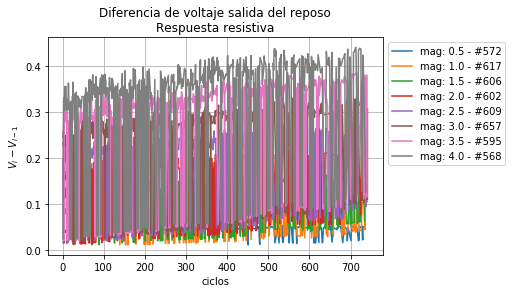

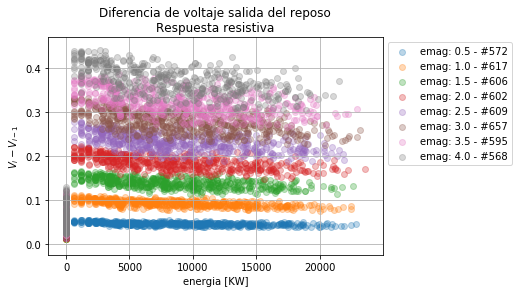

(<matplotlib.legend.Legend at 0x24cf5edfe48>, None, None)

In [64]:
WIN = 1
alpha = 0.3
df_aux = df[(df['magnitud'] >= 0.3) & (df['magnitud'] <= 0.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 0.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 0.8) & (df['magnitud'] <= 1.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 1.0 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 1.4) & (df['magnitud'] <= 1.6)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 1.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 1.8) & (df['magnitud'] <= 2.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 2.0 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 2.3) & (df['magnitud'] <= 2.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 2.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 2.8) & (df['magnitud'] <= 3.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 3.0 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 3.3) & (df['magnitud'] <= 3.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 3.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 3.8) & (df['magnitud'] <= 4.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 4.0 - #' + str(len(df_aux)))
plt.xlabel('ciclos')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.title('Diferencia de voltaje salida del reposo\nRespuesta resistiva')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

WIN = 1
alpha = 0.3
df_aux = df[(df['magnitud'] >= 0.3) & (df['magnitud'] <= 0.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 0.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 0.8) & (df['magnitud'] <= 1.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 1.0 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 1.4) & (df['magnitud'] <= 1.6)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 1.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 1.8) & (df['magnitud'] <= 2.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 2.0 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 2.3) & (df['magnitud'] <= 2.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 2.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 2.8) & (df['magnitud'] <= 3.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 3.0 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 3.3) & (df['magnitud'] <= 3.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 3.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 3.8) & (df['magnitud'] <= 4.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 4.0 - #' + str(len(df_aux)), alpha=alpha)
plt.xlabel('energia [KW]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.title('Diferencia de voltaje salida del reposo\nRespuesta resistiva')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()



Se puede ver en el gráfico anterior que hay una presencia importante de las respuestas a bajas energías, es decir, cuando ha entregado poca energía la batería. Eso se puede filtrar estableciendo un umbral inferior para la energía entregada (la etiqueta).

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


No handles with labels found to put in legend.


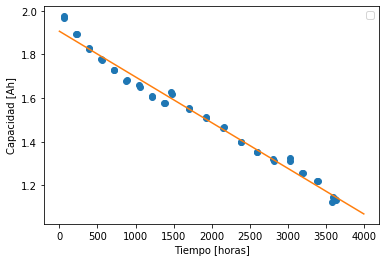

No handles with labels found to put in legend.


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


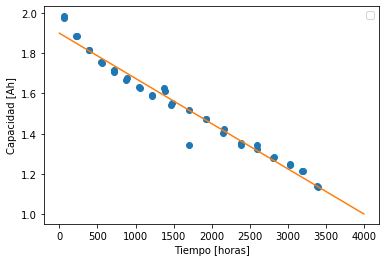

In [22]:
def plot_energia_magnitud(df, min,max, ei, ef, WIN, alpha):
    df_aux = df[(df['magnitud'] >= min) & (df['magnitud'] <= max)]
    df_aux = df_aux[(df['energia'] >= ei) & (df['energia'] <= ef)]
    df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
    df_aux = df_aux[df_aux['F1'] > 0.01]
    plt.plot(df_aux['ciclo'], df_aux['F1'],
             label='mag: ' + str((max+min)/2) + ' - #' + str(len(df_aux)) + ' i: ' + str(ei) + '-' + str(ef))
    
def plot_energia_magnitud_2(df, min,max, ei, ef, WIN, alpha,label_data):
    df_aux = df[(df['magnitud'] >= min) & (df['magnitud'] <= max)]
    df_aux = df_aux[(df['energia'] >= ei) & (df['energia'] <= ef)]
    df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
    df_aux = df_aux[df_aux['F1'] > 0.01]
    plt.plot(df_aux['ciclo'], df_aux['F1'],
             label='mag: ' + str((max+min)/2) + ' - #' + str(len(df_aux)) + ''+ 'data:' + label_data)
    
def plot_energia_magnitud_3(df, min,max, ei, ef, WIN, alpha,label_data,model):
    df_aux = df[(df['magnitud'] >= min) & (df['magnitud'] <= max)]
    df_aux = df_aux[(df['energia'] >= ei) & (df['energia'] <= ef)]
    df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
    df_aux = df_aux[df_aux['F1'] > 0.01]
    T_i = [x[0]/3600 for x in df_aux['tiempo']]
    SOH_pre = model.predict(np.reshape(T_i,(len(T_i),1)))
    plt.plot(SOH_pre, df_aux['F1'],
             label='mag: ' + str((max+min)/2) + ' - #' + str(len(df_aux)) + ''+ 'data:' + label_data)
    

from sklearn.linear_model import LinearRegression

#RW3
lista = [str('reference discharge')]
final = [str('rest post reference discharge')]
t_descarga, v_descarga, c_descarga, temp_descarga, T_descarga = carga_de_datos(documento, lista, final, nofinal=True)

# integrar la descarga
energia_entregada = []
T = []
for k in t_descarga.keys():
    energia_entregada.append(sum(c_descarga[k]) / 360)
    T.append(np.min(t_descarga[k]) / 3600)



model_1 = LinearRegression().fit(np.reshape(T,(-1,1)), np.reshape(energia_entregada,(-1,1)))
tt1 = np.arange(0,4000)
val1 = model_1.predict(np.reshape(tt1,(-1,1)))
plt.plot(T,energia_entregada,'o',tt1,val1)
#plt.scatter(T, energia_entregada, label='descarga', facecolor='none', s=88, edgecolors='b', alpha=0.8)
plt.ylabel('Capacidad [Ah]')
plt.xlabel('Tiempo [horas]'),
plt.legend()
plt.show()

#RW5

lista_2 = [str('reference discharge')]
final_2 = [str('rest post reference discharge')]
t_descarga_2, v_descarga_2, c_descarga_2, temp_descarga_2, T_descarga_2 = carga_de_datos(documento_2, lista_2, final_2, nofinal=True)

# integrar la descarga
energia_entregada_2 = []
T_2 = []
for k in t_descarga_2.keys():
    energia_entregada_2.append(sum(c_descarga_2[k]) / 360)
    T_2.append(np.min(t_descarga[k]) / 3600)



model_2 = LinearRegression().fit(np.reshape(T_2,(-1,1)), np.reshape(energia_entregada_2,(-1,1)))
tt2 = np.arange(0,4000)
val2 = model_2.predict(np.reshape(tt2,(-1,1)))
plt.plot(T_2,energia_entregada_2,'o',tt2,val2)
#plt.scatter(T, energia_entregada, label='descarga', facecolor='none', s=88, edgecolors='b', alpha=0.8)
plt.ylabel('Capacidad [Ah]')
plt.xlabel('Tiempo [horas]'),
plt.legend()
plt.show()






In [26]:
def data_valid_2(data_x,data_y,porcentaje,n,rs=None):
    data_valid_x = np.empty((0,data_x.shape[1]))
    data_valid_y = np.empty((0,data_y.shape[1]))
    new_data_x = data_x
    new_data_y = data_y
    por_stop = porcentaje/(100-porcentaje)
    por_act = 0
    l = len(new_data_x)-1
    while(por_act<por_stop):
        idx = np.random.randint(0,l)
        idx_fn = idx+n-1
        if(idx_fn<l):
            for i in range(n):
                idx_act = idx
                pop_x = poprow(new_data_x,idx_act)
                pop_y = poprow(new_data_y,idx_act)
                data_valid_x = np.append(data_valid_x,np.reshape(pop_x[1],(1,-1)),axis=0)
                data_valid_y = np.append(data_valid_y,np.reshape(pop_y[1],(1,-1)),axis=0)
                new_data_x = pop_x[0]
                new_data_y = pop_y[0]
        l = new_data_x.shape[0]-1
        l_valid = data_valid_x.shape[0]-1
        por_act = l_valid/l
    np.random.seed(rs)
    #data_train = np.hstack((new_data_x,np.reshape(new_data_y,(-1,1))))
    data_train = np.hstack((new_data_x,new_data_y))
    np.random.shuffle(data_train)
    data_train_x = data_train[:,:-2]
    data_train_y = data_train[:,-2:]
    return [data_train_x,data_train_y,data_valid_x,data_valid_y]

def Mean_n_2(data_1,data_2, n):
    aux = np.zeros((len(data_1),2))
    rg = int(len(data_1)/n)
    for i in range(rg):
        aux[i*n:i*n+n,0] =  np.mean(data_1[i*n:i*n+n])
        aux[i*n:i*n+n,1] = np.mean(data_2[i*n:i*n+n])
    if(i*n+n<len(data)):
        aux[i*n+n:,0] = np.mean(data_1[i*n+n:])
        aux[i*n+n:,1] = np.mean(data_2[i*n+n:])
    return aux

def toLabel(data_y,maximo,minimo,n):
    size = (maximo-minimo)/n
    labels = [int((i-minimo)/size)+1 for i in data_y]
    return labels
    
    

after filter:  (9672, 24)
firt filter energia >10000:  (3876, 24)
second filter F2 = Nan: (3876, 24)
second filter F8 = inf: (3760, 24)


No handles with labels found to put in legend.


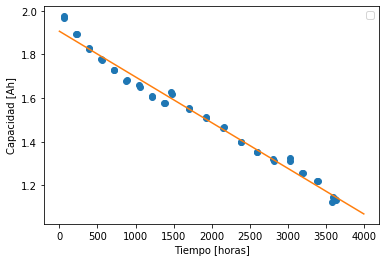

C:\Users\cbaez\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\cbaez\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.8013071895424837


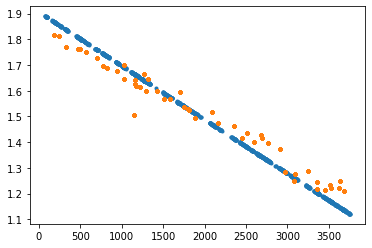

In [48]:
from sklearn.ensemble import RandomForestRegressor
data_1 = df.values
data_2 = df_2.values
data = np.vstack((data_1,data_2))
# np.random.shuffle(data)
Nombres = df.columns.values

data_y_reg = np.zeros((data.shape[0],2))
for i in range(data.shape[0]):
    val = model_1.predict(np.reshape(data[i,7][0]/3600,(-1,1)))
    data_y_reg[i,0] = val
    data_y_reg[i,1] = data[i,7][0]/3600
    
    
#16 = f2 17=f3
print("after filter: ", data.shape)
energi= 10000
ind = np.where((data[:,1]>5000)) 
data = np.delete(data,ind,axis=0)
data_y_reg =  np.delete(data_y_reg,ind,axis=0)
print("firt filter energia >%s: " %energi , data.shape)

# ind = np.where((data[:,1]<150)) 
# data = np.delete(data,ind,axis=0)
# print("firt filter energia <150: " , data.shape)

aux = data[:,15].astype(np.float64)
ind_2 = np.argwhere(np.isnan(aux))
data = np.delete(data,ind_2,axis=0)
data_y_reg =  np.delete(data_y_reg,ind_2,axis=0)
print("second filter F2 = Nan:" , data.shape)

aux_2 = data[:,21].astype(np.float64)
ind_3 = np.argwhere(np.isinf(aux_2))
data = np.delete(data,ind_3,axis=0)
data_y_reg =  np.delete(data_y_reg,ind_3,axis=0)
print("second filter F8 = inf:" , data.shape)

# Data con energia total consumida

#data_x = np.hstack((data[:,3:5],data[:,9:22]))
#Data sin energia total consumida

data_temp = np.reshape(data[:,8],(-1,1))
#print(data_temp.shape)
# data_x = np.hstack((data[:,3:5],data_temp,data[:,11:22]))
data_x = np.hstack((data[:,1:4],data_temp,data[:,10:23]))
Nombres_featu = np.hstack((Nombres[1:4],Nombres[8],Nombres[10:23]))


data_y = data[:,-1]
data_y = data_y.astype(int)
#print("datax: ",data_x.shape)

#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(data_x)
# data_x = PCA(n_components=8).fit_transform(scaler_data)

Sel_best = SelectKBest(mutual_info_classif, k=7)
Sel_best.fit(scaler_data, data_y)
Best_Sel = Sel_best.get_support()
Data_sel = [str(Nombres_featu[i])+":"+ str(Best_Sel[i]) for i in range(len(Best_Sel))]
#print(Data_sel)

data_x = Sel_best.transform(scaler_data)

win = 30

x_train, y_train, x_valid, y_valid = data_valid_2(data_x, data_y_reg,40, win)



regr = RandomForestRegressor(n_estimators=200,random_state=0)
regr.fit(x_train,y_train[:,0])
y_pred = regr.predict(x_valid)

plt.plot(T,energia_entregada,'o',tt1,val1)
#plt.scatter(T, energia_entregada, label='descarga', facecolor='none', s=88, edgecolors='b', alpha=0.8)
plt.ylabel('Capacidad [Ah]')
plt.xlabel('Tiempo [horas]'),
plt.legend()
plt.show()

plt.plot(y_valid[:,1],y_valid[:,0],linestyle='None',marker=".")


y_pred_post = Mean_n_2(y_pred,y_valid[:,1],win)


plt.plot(y_pred_post[:,1],y_pred_post[:,0],linestyle='None',marker=".")

minimo = min(data_y_reg[:,0])
maximo = max(data_y_reg[:,0])

y_lab = toLabel(y_valid[:,0],minimo,maximo,5)
y_lab_pred = toLabel(y_pred_post[:,0],minimo,maximo,5)

print(accuracy_score(y_lab, y_lab_pred))

C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


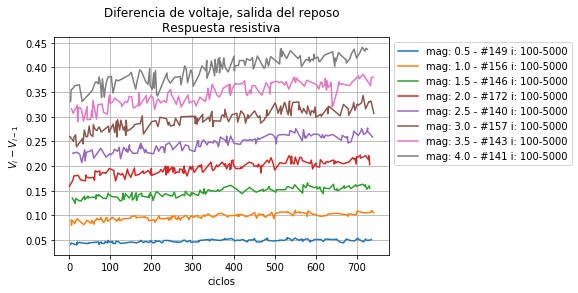

(<matplotlib.legend.Legend at 0x24cf5753320>, None, None)

In [66]:

WIN = 1
plot_energia_magnitud(df, 0.3,0.7, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 0.8,1.2, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.3,1.7, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.8,2.2, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.3,2.7, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.8,3.2, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 3.3,3.7, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 3.8,4.2, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 20000, 25000, WIN, alpha)
plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('ciclos')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()


C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


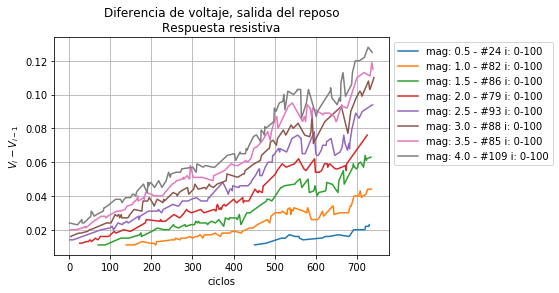

(<matplotlib.legend.Legend at 0x24cf3ca3b70>, None, None)

In [67]:
WIN = 1
alpha = 0.3
plot_energia_magnitud(df, 0.3,0.7,0, 100, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 0.8,1.2, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.3,1.7, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.8,2.2, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.3,2.7, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.8,3.2, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 3.3,3.7, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()


plot_energia_magnitud(df, 3.8,4.2, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 20000, 25000, WIN, alpha)
plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('ciclos')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()


In [68]:
WIN = 1
alpha = 0.3
plt.figure()
plot_energia_magnitud_3(df, 0.3,0.7,0, 100, WIN, alpha , 'RW3',model_1)
plot_energia_magnitud_3(df_2, 0.3,0.7,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 0.8,1.2,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 0.8,1.2,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 1.3,1.7,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 1.3,1.7,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 1.8,2.2,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 1.8,2.2,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 2.3,2.7,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 2.3,2.7,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 2.8,3.2,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 2.8,3.2,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 3.3,3.7,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 3.3,3.7,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 3.8,4.2,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 3.8,4.2,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

NameError: name 'model_1' is not defined

<Figure size 432x288 with 0 Axes>

In [69]:
def energia_magnitud(df,df_2, min,max, ei, ef, WIN, alpha,label_data,model):
    df_aux = df[(df['magnitud'] >= min) & (df['magnitud'] <= max)]
    df_aux = df_aux[(df['energia'] >= ei) & (df['energia'] <= ef)]
    df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
    df_aux = df_aux[df_aux['F1'] > 0.01]
    T_i = [x[0]/3600 for x in df_aux['tiempo']]
    SOH_pre = model.predict(np.reshape(T_i,(len(T_i),1)))
    model_aux = LinearRegression().fit(np.reshape(df_aux['F1'].values,(len(df_aux['F1'].values),1)),np.reshape(SOH_pre,(len(SOH_pre),1)))
    df_aux_test = df_2[(df_2['magnitud'] >= min) & (df_2['magnitud'] <= max)]
    df_aux_test = df_aux_test[(df_2['energia'] >= ei) & (df_2['energia'] <= ef)]
    df_aux_test['F1'] = df_aux_test['F1'].rolling(window=WIN).mean()
    df_aux_test = df_aux_test[df_aux_test['F1'] > 0.01]
    SOH_pre_test = model_aux.predict(np.reshape(df_aux_test['F1'].values,(len(df_aux_test['F1'].values),1)))
    plt.plot(SOH_pre_test, df_aux_test['F1'],
             label='mag: ' + str((max+min)/2) + ' - #' + str(len(df_aux)) + ''+ 'data:' + label_data)

In [70]:
WIN = 1
alpha = 0.3

plt.figure()
energia_magnitud(df,df_2 ,0.3,0.7,0, 100, WIN, alpha , 'RW4 PRE',model_1)
plot_energia_magnitud_3(df_2, 0.3,0.7,0, 100, WIN, alpha, 'RW4 REAL',model_2)
plot_energia_magnitud_3(df, 0.3,0.7,0, 100, WIN, alpha, 'RW3',model_1)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
energia_magnitud(df,df_2 ,0.8,1.2,0, 100, WIN, alpha , 'RW4 PRE',model_1)
plot_energia_magnitud_3(df_2, 0.8,1.2,0, 100, WIN, alpha, 'RW4 REAL',model_2)
plot_energia_magnitud_3(df, 0.8,1.2,0, 100, WIN, alpha, 'RW3',model_1)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
energia_magnitud(df,df_2 ,1.3,1.7,0, 100, WIN, alpha , 'RW4 PRE',model_1)
plot_energia_magnitud_3(df_2, 1.3,1.7,0, 100, WIN, alpha, 'RW4 REAL',model_2)
plot_energia_magnitud_3(df, 1.3,1.7,0, 100, WIN, alpha, 'RW3',model_1)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
energia_magnitud(df,df_2 ,1.8,2.2,0, 100, WIN, alpha , 'RW4 PRE',model_1)
plot_energia_magnitud_3(df_2, 1.8,2.2,0, 100, WIN, alpha, 'RW4 REAL',model_2)
plot_energia_magnitud_3(df, 1.8,2.2,0, 100, WIN, alpha, 'RW3',model_1)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
energia_magnitud(df,df_2 ,2.3,2.7,0, 100, WIN, alpha , 'RW4 PRE',model_1)
plot_energia_magnitud_3(df_2, 2.3,2.7,0, 100, WIN, alpha, 'RW4 REAL',model_2)
plot_energia_magnitud_3(df, 2.3,2.7,0, 100, WIN, alpha, 'RW3',model_1)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
energia_magnitud(df,df_2 ,2.8,3.2,0, 100, WIN, alpha , 'RW4 PRE',model_1)
plot_energia_magnitud_3(df_2, 2.8,3.2,0, 100, WIN, alpha, 'RW4 REAL',model_2)
plot_energia_magnitud_3(df, 2.8,3.2,0, 100, WIN, alpha, 'RW3',model_1)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
energia_magnitud(df,df_2 ,3.3,3.7,0, 100, WIN, alpha , 'RW4 PRE',model_1)
plot_energia_magnitud_3(df_2, 3.3,3.7,0, 100, WIN, alpha, 'RW4 REAL',model_2)
plot_energia_magnitud_3(df, 3.3,3.7,0, 100, WIN, alpha, 'RW3',model_1)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
energia_magnitud(df,df_2 ,3.8,4.2,0, 100, WIN, alpha , 'RW4 PRE',model_1)
plot_energia_magnitud_3(df_2,3.8,4.2,0, 100, WIN, alpha, 'RW4 REAL',model_2)
plot_energia_magnitud_3(df, 3.8,4.2,0, 100, WIN, alpha, 'RW3',model_1)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH [Ah]')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')


NameError: name 'model_1' is not defined

<Figure size 432x288 with 0 Axes>

In [71]:
# comportamiento de potencia instantanea entregada
def potencia_instantanea_salto(arr_voltaje, arr_corriente, limite=10):
    aux = np.zeros(len(arr_voltaje))
    for i, serie in enumerate(arr_corriente):
        serie = serie[1:]
        contador = 0
        for j, c in enumerate(serie):
            if c != 0 and aux[i] == 0:
                aux[i] = c * arr_voltaje[i][j]
                contador = 1
            elif c != 0 and contador < limite:
                aux[i] += c * arr_voltaje[i][j]
                contador += 1
            elif contador == limite: break
            
    return aux

In [72]:
df['F1'] = potencia_instantanea_salto(df['voltaje'], df['corriente'], limite=1)
df

,ciclo,energia,magnitud,media,voltaje,corriente,temperatura,tiempo,temp_ini,F1,...,F3,F4,F5,F6,F7,Mag_rel,Mediana_rel,Mag_rel_abs,Mediana_rel_abs,clase
0,1,0.614047,4.005,2.0025,"[4.199, 4.199, 3.833, 3.809, 3.801, 3.795, 3.7...","[0.0, 0.0, 4.005, 3.999, 4.0, 3.999, 4.0, 4.0,...","[20.61039, 20.61039, 20.61039, 20.62594, 20.62...","[274884.25, 274884.5, 274884.54, 274885.540000...",20.61039,16.816995,...,1.890272,0.000000,0.000000,0.00000,16.816995,4.005,2.0025,4.005,2.0025,1
1,1,4266.690109,2.007,1.0035,"[3.512, 3.817, 3.842, 3.683, 3.688, 3.693, 3.6...","[4.0, 0.0, 0.0, 2.007, 2.0, 2.0, 2.0, 2.0, 2.0...","[28.18093, 28.18093, 28.18093, 28.18093, 28.21...","[275184.5, 275184.50999999995, 275184.7, 27518...",28.18093,7.710894,...,0.092950,0.002133,-0.002732,70.30368,7.710894,1.998,0.9990,1.998,0.9990,1
2,1,6510.697143,1.503,0.7515,"[3.72, 3.868, 3.879, 3.763, 3.762, 3.763, 3.76...","[2.0, 0.0, 0.0, 1.503, 1.5, 1.5, 1.5, 1.5, 1.5...","[28.36748, 28.36748, 28.36748, 28.36748, 28.35...","[275484.7, 275484.71, 275485.35, 275485.39, 27...",28.36748,5.830137,...,0.744684,0.001068,-0.003442,26.98008,5.830137,0.504,0.2520,0.504,0.2520,1
3,1,8200.072656,2.504,1.2520,"[3.733, 3.846, 3.854, 3.657, 3.652, 3.65, 3.64...","[1.5, 0.0, 0.0, 2.504, 2.5, 2.5, 2.5, 2.499, 2...","[27.24822, 27.24822, 27.23267, 27.23267, 27.23...","[275785.35, 275785.36, 275785.81, 275785.85, 2...",27.24822,9.650416,...,0.329034,0.000000,0.000000,0.00000,9.650416,-1.001,-0.5005,1.001,0.5005,1
4,1,10884.859898,0.504,0.2520,"[3.543, 3.731, 3.747, 3.708, 3.711, 3.715, 3.7...","[2.5, 0.0, 0.0, 0.504, 0.5, 0.5, 0.5, 0.5, 0.5...","[28.07212, 28.07212, 28.07212, 28.07212, 28.07...","[276085.81, 276085.82, 276086.28, 276086.33, 2...",28.07212,1.888488,...,3.762956,0.001446,-0.001126,105.24064,1.888488,2.000,1.0000,2.000,1.0000,1
5,1,11451.628610,2.505,1.2525,"[3.787, 3.825, 3.828, 3.629, 3.623, 3.619, 3.6...","[0.5, 0.0, 0.0, 2.505, 2.499, 2.5, 2.5, 2.5, 2...","[26.17559, 26.17559, 26.17559, 26.17559, 26.16...","[276386.28, 276386.29000000004, 276386.87, 276...",26.17559,9.589140,...,0.533693,0.000000,0.000000,0.00000,9.589140,-2.001,-1.0005,2.001,1.0005,1
6,1,14086.032912,1.005,0.5025,"[3.474, 3.663, 3.683, 3.603, 3.604, 3.607, 3.6...","[2.501, 0.0, 0.0, 1.005, 1.0, 0.999, 1.0, 0.99...","[27.51249, 27.51249, 27.51249, 27.51249, 27.51...","[276686.87, 276686.88, 276687.33, 276687.37, 2...",27.51249,3.701415,...,1.175562,0.001397,-0.001462,81.84400,3.701415,1.500,0.7500,1.500,0.7500,1
7,1,15181.589734,2.005,1.0025,"[3.654, 3.73, 3.737, 3.576, 3.571, 3.569, 3.56...","[1.0, 0.0, 0.0, 2.005, 2.0, 2.0, 2.0, 2.0, 2.0...","[26.33105, 26.33105, 26.33105, 26.33105, 26.31...","[276987.33, 276987.34, 276987.88, 276987.92000...",26.33105,7.492685,...,0.302374,0.000000,0.000000,0.00000,7.492685,-1.000,-0.5000,1.000,0.5000,1
8,1,17288.851126,3.003,1.5015,"[3.489, 3.64, 3.657, 3.412, 3.403, 3.401, 3.39...","[2.0, 0.0, 0.0, 3.003, 3.001, 3.0, 3.0, 3.0, 3...","[26.93731, 26.93731, 26.93731, 26.93731, 26.95...","[277287.88, 277287.89, 277288.08, 277288.12, 2...",26.93731,10.981971,...,1.158188,0.000000,0.000000,0.00000,10.981971,-0.998,-0.4990,0.998,0.4990,1
9,1,20293.072460,1.002,0.5010,"[3.305, 3.528, 3.559, 3.479, 3.484, 3.489, 3.4...","[3.0, 0.0, 0.0, 1.002, 1.001, 0.999, 1.0, 0.99...","[30.41535, 30.41535, 30.41535, 30.41535, 30.43...","[277588.08, 277588.08999999997, 277588.32, 277...",30.41535,3.566118,...,1.749012,0.002093,-0.001742,80.44096,3.566118,2.001,1.0005,2.001,1.0005,1


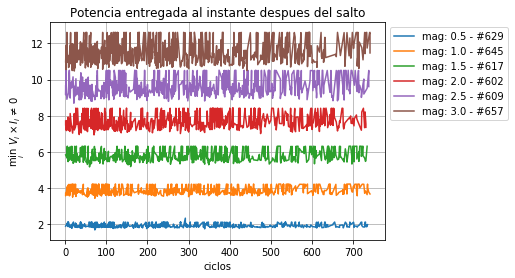

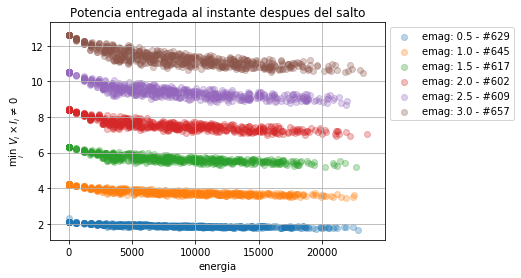

(<matplotlib.legend.Legend at 0x24ceea10c18>, None, None)

In [73]:
WIN = 1
df_aux = df[(df['magnitud'] >= 0.3) & (df['magnitud'] <= 0.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 0.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 0.8) & (df['magnitud'] <= 1.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 1.0 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 1.4) & (df['magnitud'] <= 1.6)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 1.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 1.8) & (df['magnitud'] <= 2.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 2.0 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 2.3) & (df['magnitud'] <= 2.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 2.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 2.8) & (df['magnitud'] <= 3.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 3.0 - #' + str(len(df_aux)))

# df_aux = df[(df['magnitud'] >= 3.3) & (df['magnitud'] <= 3.7)]
# df_aux = df_aux[df_aux['F1'] > 0.01]
# df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
# plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 3.5 - #' + str(len(df_aux)))

# df_aux = df[(df['magnitud'] >= 3.8) & (df['magnitud'] <= 4.2)]
# df_aux = df_aux[df_aux['F1'] > 0.01]
# df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
# plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 4.0 - #' + str(len(df_aux)))
plt.xlabel('ciclos')
plt.ylabel(r'$\min_i \ V_i \times I_i \ \ne \ 0$')
plt.title('Potencia entregada al instante despues del salto')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

WIN = 1
alpha = 0.3
df_aux = df[(df['magnitud'] >= 0.3) & (df['magnitud'] <= 0.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 0.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 0.8) & (df['magnitud'] <= 1.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 1.0 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 1.4) & (df['magnitud'] <= 1.6)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 1.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 1.8) & (df['magnitud'] <= 2.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 2.0 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 2.3) & (df['magnitud'] <= 2.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 2.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 2.8) & (df['magnitud'] <= 3.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 3.0 - #' + str(len(df_aux)), alpha=alpha)

# df_aux = df[(df['magnitud'] >= 3.3) & (df['magnitud'] <= 3.7)]
# df_aux = df_aux[df_aux['F1'] > 0.01]
# df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
# plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 3.5 - #' + str(len(df_aux)), alpha=alpha)

# df_aux = df[(df['magnitud'] >= 3.8) & (df['magnitud'] <= 4.2)]
# df_aux = df_aux[df_aux['F1'] > 0.01]
# df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
# plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 4.0 - #' + str(len(df_aux)), alpha=alpha)
plt.xlabel('energia')
plt.ylabel(r'$\min_i \ V_i \times I_i \ \ne \ 0$')
plt.title('Potencia entregada al instante despues del salto')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()



In [ ]:
WIN = 5
plot_energia_magnitud(df, 0.5, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.0, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.5, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.0, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.5, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 3.0, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 3.5, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 4.0, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 20000, 25000, WIN, alpha)
plt.ylabel(r'$\min_i \ V_i \times I_i \ \ne \ 0$')
plt.title('Potencia entregada al instante despues del salto')
plt.xlabel('ciclos')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()


In [ ]:
def tiempo_a_inflexion(arr_voltaje):
    """
    funcion que entrega el tiempo necesario a la inflexion
    """
    
    
    
    return

Trabajo próximo:
- guardar curvas hasta el salto anterior (instante antes de 0)
- guardar voltaje anterior como etiqueta
- guardar temperatura inicial como etiqueta
- Para feature de degradación usar delta T del salto completo (inicio - fin)
- Ver fenomenolgía del circuito RC, ajustar función de transferencia de modelo RC
    - para encontrar la constante de proporcionalidad, tomar curvas de voltaje 'estables' donde $V_{i+1} - V_{i} < \epsilon$
    - Encontrar constante de tiempo entre esas curvas

# Grafico de curva de salud

In [ ]:
# lista = [str('reference charge')]
# final = [str('rest post reference charge')]
# t_carga, v_carga, c_carga, temp_carga, T_carga = carga_de_datos(documento, lista, final, nofinal=True)

lista = [str('reference discharge')]
final = [str('rest post reference discharge')]
t_descarga, v_descarga, c_descarga, temp_descarga, T_descarga = carga_de_datos(documento, lista, final, nofinal=True)


In [ ]:
# integrar la descarga
energia_entregada = []
T = []
for k in t_descarga.keys():
    energia_entregada.append(sum(c_descarga[k]) / 360)
    T.append(np.min(t_descarga[k]) / 3600)
plt.scatter(T, energia_entregada, label='descarga', facecolor='none', s=88, edgecolors='b', alpha=0.8)
plt.ylabel('Capacidad [Ah]')
plt.xlabel('Tiempo [horas]')
plt.legend()

# plt.title('Capacidad de energía entregada por batería'), plt.show()

# # integrar la carga
# energia_entregada = []
# T = []
# for k in t_carga.keys():
#     energia_entregada.append(sum(c_carga[k]) / 360)
#     T.append(np.mean(t_carga[k]) / 3600)
# # plt.scatter(T, np.abs(energia_entregada), label='carga', s=38, edgecolors='b', alpha=0.4)
# plt.ylabel('Capacidad [Ah]')
# plt.xlabel('Tiempo [horas]')
# plt.legend()
# plt.title('Capacidad de energía'), plt.show()


[ciclo, potencia, media y magnitud del salto] como identidad de un salto, a partir de ello obtener una respuesta dinamica con features